Optimization terminated successfully.
         Current function value: 0.421544
         Iterations 6
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2508
           1       0.56      0.05      0.09       492

    accuracy                           0.84      3000
   macro avg       0.70      0.52      0.50      3000
weighted avg       0.80      0.84      0.78      3000

Optimization terminated successfully.
         Current function value: 0.628656
         Iterations 6
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      2508
           1       0.27      0.67      0.38       492

    accuracy                           0.64      3000
   macro avg       0.59      0.66      0.57      3000
weighted avg       0.80      0.64      0.69      3000

Optimization terminated successfully.
         Current function value: 0.621254
         Iterations 6
              precision    recall  f1-sc

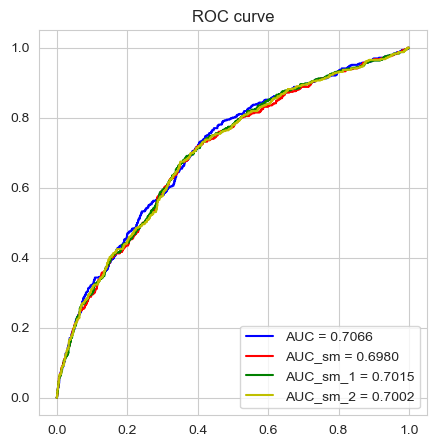

In [3]:
import os
# 分割测试集训练集
from sklearn.model_selection import train_test_split
# 模型评估（召回率），选择0.5为阈值
from sklearn.metrics import classification_report
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
os.chdir(r'C:\Users\fzh00\Desktop\文件\python资料\Python数据清洗基础\data\2_逻辑回归案例')
data = pd.read_excel('客户列表.xls')
# data.head()
#‘成交意向度’为系统输出，这里不需要
data.drop('成交意向度', axis=1, inplace=True)
data.rename(columns={'客户ID':'ID', '对话时长(总时长/对话数量)':'对话时长', '互动次数(总次数/对话数量)':'互动次数',
                    '是否已成交(1已成交0未成交)':'是否成交'}, inplace=True)
# 去掉变量ID
data.drop('ID', axis=1, inplace=True)
train,test = train_test_split(data,test_size=0.3,random_state=6)

train.head(3)
train.columns
#拟合模型
formula = '是否成交~对话数量+对话时长+互动次数+销售说话时长占比+销售最长讲述+客户最长讲述+对话得分'
model = smf.logit(formula,train) #实例化
model = model.fit() #拟合数据
model.summary() #输出结果
#输出预测概率
pre = model.predict(test.iloc[:,:-1])
#预测标签
label = (pre>0.5).astype('int')
#输出 分类报告,Y的真实值 和预测标签
print(classification_report(test.iloc[:,-1],label))

#下面是模型调优
#SMOTE,处理不平衡数据的方法
train['是否成交'].value_counts()
# SMOTE过采样:对训练集进行过采
from imblearn.over_sampling import SMOTE

#过采样（SMOTE）
smote = SMOTE(random_state=42)   #实例化
Xtrain_sm,  Ytrain_sm= smote.fit_resample(train.iloc[:,:-1], train.iloc[:,-1])   #过采样
#合并过采样后的自变量与因变量
train_sm = pd.concat([Xtrain_sm, Ytrain_sm], axis=1)
#重新拟合模型
formula2='是否成交~对话数量+对话时长+互动次数+销售说话时长占比+销售最长讲述+客户最长讲述+对话得分'
model_sm = smf.logit(formula=formula2, data=train_sm)   #实例化
model_sm = model_sm.fit()   #拟合数据
model_sm.summary()
#预测
pre_sm = model_sm.predict(test.iloc[:,:-1])
(pre_sm>0.5).sum()
#输出 分类报告,Y的真实值 和预测标签
print(classification_report(test.iloc[:,-1],(pre_sm>0.5).astype('int')))
#混淆矩阵，默认阈值0.5
model_sm.pred_table()
#改进方法BorderlineSMOTE1
from imblearn.over_sampling import BorderlineSMOTE
smote_b1 = BorderlineSMOTE(random_state=123)
Xtrain_sm_1,Ytrain_sm_1 = smote_b1.fit_resample(train.iloc[:,:-1],train.iloc[:,-1])
train_sm_1 = pd.concat([Xtrain_sm_1, Ytrain_sm_1],axis=1)
train_sm_1.shape
formula3='是否成交~对话数量+对话时长+互动次数+销售说话时长占比+销售最长讲述+客户最长讲述+对话得分'
model_sm_1 = smf.logit(formula=formula3, data=train_sm_1).fit()
model_sm_1.summary()
pre_label_sm_1= (model_sm_1.predict(test) > 0.5).astype("int")   # 生成预测值
print(classification_report(test.iloc[:,-1], pre_label_sm_1))   # Y的真实值，Y的预测值

#改进方法BorderlineSMOTE2
smote_b2 = BorderlineSMOTE(random_state=123, kind='borderline-2') #默认SMOTE1
Xtrain_sm_2,Ytrain_sm_2 = smote_b2.fit_resample(train.iloc[:,:-1],train.iloc[:,-1])
train_sm_2 = pd.concat([Xtrain_sm_2, Ytrain_sm_2],axis=1)
formula4='是否成交~对话数量+对话时长+互动次数+销售说话时长占比+销售最长讲述+客户最长讲述+对话得分'
model_sm_2 = smf.logit(formula=formula4, data=train_sm_2).fit()
model_sm_2.summary()

pre_label_sm_2= (model_sm_2.predict(test) > 0.5).astype("int")   # 生成预测值
print(classification_report(test.iloc[:,-1], pre_label_sm_2))   # Y的真实值，Y的预测值

#预测出来的标签的结果，用于得到分类报告的
pre_sm_1 = model_sm_1.predict(test)
pre_sm_2 = model_sm_2.predict(test)

#模型评估
from sklearn import metrics
#将真实的标签值与预测出来的为1的概率值传入metrics.roc_curve（），返回的是一系列的tpr、fpr、阈值的取值情况
fpr, tpr, th = metrics.roc_curve(test.iloc[:,-1], pre)
fpr_sm, tpr_sm, th_sm = metrics.roc_curve(test.iloc[:,-1], pre_sm)
fpr_sm_1, tpr_sm_1, th_sm_1 = metrics.roc_curve(test.iloc[:,-1], pre_sm_1)
fpr_sm_2, tpr_sm_2, th_sm_2 = metrics.roc_curve(test.iloc[:,-1], pre_sm_2)

#绘图
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, 'b', label='AUC = %.4f' %metrics.auc(fpr, tpr))
plt.plot(fpr_sm, tpr_sm, 'r', label='AUC_sm = %.4f' %metrics.auc(fpr_sm, tpr_sm))
plt.plot(fpr_sm_1, tpr_sm_1, 'g', label='AUC_sm_1 = %.4f' %metrics.auc(fpr_sm_1, tpr_sm_1))
plt.plot(fpr_sm_2, tpr_sm_2, 'y', label='AUC_sm_2 = %.4f' %metrics.auc(fpr_sm_2, tpr_sm_2))


plt.legend(loc = 'lower right')
plt.title('ROC curve')
plt.show();

In [85]:
DT_model = joblib.load("model_logit.joblib")   # 读取模型

DT_model.predict([[3, 50, 10, 20, 50, 3, 2,1]])   # 直接用读取的模型做预测

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\patsy\compat.py", line 36, in call_and_wrap_exc
    return f(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\patsy\eval.py", line 169, in eval
    return eval(code, {}, VarLookupDict([inner_namespace]
  File "<string>", line 1, in <module>
  File "C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\patsy\eval.py", line 52, in __getitem__
    return d[key]
  File "C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\patsy\eval.py", line 52, in __getitem__
    return d[key]
TypeError: list indices must be integers or slices, not str

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\statsmodels\base\model.py", line 1137, in predict
    exog = dmatrix(design_inf

In [84]:
import joblib
file = 'model_logit.joblib'
joblib.dump(model,file)   # 保存模型

['model_logit.joblib']

In [83]:
#最优阈值（约登指数）
th[(tpr - fpr).argmax()]

0.15133468729857574

In [82]:
th_2[(tpr_2 - fpr_2).argmax()]

NameError: name 'th_2' is not defined

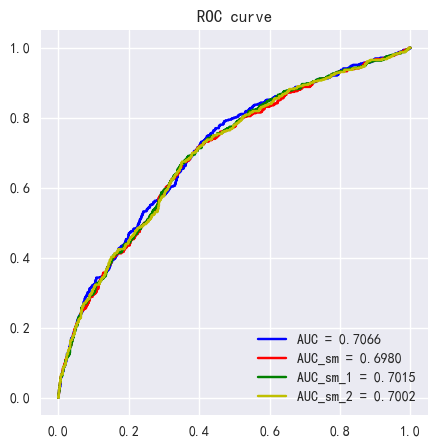

In [81]:
#绘图
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, 'b', label='AUC = %.4f' %metrics.auc(fpr, tpr))
plt.plot(fpr_sm, tpr_sm, 'r', label='AUC_sm = %.4f' %metrics.auc(fpr_sm, tpr_sm))
plt.plot(fpr_sm_1, tpr_sm_1, 'g', label='AUC_sm_1 = %.4f' %metrics.auc(fpr_sm_1, tpr_sm_1))
plt.plot(fpr_sm_2, tpr_sm_2, 'y', label='AUC_sm_2 = %.4f' %metrics.auc(fpr_sm_2, tpr_sm_2))


plt.legend(loc = 'lower right')
plt.title('ROC curve')
plt.show();

In [80]:
#阈值
th

array([1.98087624, 0.98087624, 0.95838503, 0.94205309, 0.8548016 ,
       0.81624767, 0.69892546, 0.69469714, 0.63209192, 0.61359189,
       0.5969097 , 0.59679051, 0.57429837, 0.55038754, 0.54804891,
       0.54564437, 0.54389198, 0.5437722 , 0.53872316, 0.53613977,
       0.51595693, 0.5130805 , 0.50895727, 0.50781168, 0.4628992 ,
       0.45689277, 0.45176462, 0.43793785, 0.43248584, 0.4324046 ,
       0.42572147, 0.41844081, 0.4182507 , 0.41467543, 0.41380922,
       0.41198908, 0.41125988, 0.40553092, 0.40198611, 0.39833398,
       0.39592625, 0.3942522 , 0.3907481 , 0.38985529, 0.38786686,
       0.38649362, 0.38628179, 0.37524459, 0.3688054 , 0.36496019,
       0.36304947, 0.36155627, 0.35761099, 0.35514244, 0.35093617,
       0.34985957, 0.34937768, 0.34386099, 0.3410599 , 0.33830787,
       0.33604074, 0.33577274, 0.33561915, 0.33397101, 0.32978044,
       0.32341157, 0.32232876, 0.32195941, 0.32044753, 0.31552728,
       0.31537115, 0.31492914, 0.31277992, 0.31230649, 0.31100

In [79]:
#真阳性率
tpr

array([0.        , 0.        , 0.00203252, 0.00203252, 0.00813008,
       0.00813008, 0.01219512, 0.01219512, 0.02235772, 0.02235772,
       0.02439024, 0.02439024, 0.02845528, 0.02845528, 0.0304878 ,
       0.0304878 , 0.03252033, 0.03252033, 0.03455285, 0.03455285,
       0.04065041, 0.04065041, 0.04471545, 0.04471545, 0.05691057,
       0.05691057, 0.05894309, 0.05894309, 0.06504065, 0.06504065,
       0.06707317, 0.06707317, 0.06910569, 0.06910569, 0.07317073,
       0.07317073, 0.07520325, 0.07520325, 0.07723577, 0.07723577,
       0.08130081, 0.08130081, 0.08536585, 0.08536585, 0.08739837,
       0.08739837, 0.08943089, 0.08943089, 0.09146341, 0.09146341,
       0.09349593, 0.09349593, 0.09552846, 0.09552846, 0.10162602,
       0.10162602, 0.10365854, 0.10365854, 0.11382114, 0.11382114,
       0.11585366, 0.11585366, 0.11788618, 0.11788618, 0.12601626,
       0.12601626, 0.12804878, 0.12804878, 0.1300813 , 0.1300813 ,
       0.13211382, 0.13211382, 0.13821138, 0.13821138, 0.14227

In [78]:
#模型评估
from sklearn import metrics
#将真实的标签值与预测出来的为1的概率值传入metrics.roc_curve（），返回的是一系列的tpr、fpr、阈值的取值情况
fpr, tpr, th = metrics.roc_curve(test.iloc[:,-1], pre)
fpr_sm, tpr_sm, th_sm = metrics.roc_curve(test.iloc[:,-1], pre_sm)
fpr_sm_1, tpr_sm_1, th_sm_1 = metrics.roc_curve(test.iloc[:,-1], pre_sm_1)
fpr_sm_2, tpr_sm_2, th_sm_2 = metrics.roc_curve(test.iloc[:,-1], pre_sm_2)
#假阳性率
fpr

array([0.00000000e+00, 3.98724083e-04, 3.98724083e-04, 1.19617225e-03,
       1.19617225e-03, 1.59489633e-03, 1.59489633e-03, 1.99362041e-03,
       1.99362041e-03, 2.79106858e-03, 2.79106858e-03, 3.18979266e-03,
       3.18979266e-03, 4.78468900e-03, 4.78468900e-03, 5.18341308e-03,
       5.18341308e-03, 5.58213716e-03, 5.58213716e-03, 6.37958533e-03,
       6.37958533e-03, 6.77830941e-03, 6.77830941e-03, 7.17703349e-03,
       7.17703349e-03, 8.37320574e-03, 8.37320574e-03, 9.56937799e-03,
       9.56937799e-03, 9.96810207e-03, 9.96810207e-03, 1.03668262e-02,
       1.03668262e-02, 1.11642743e-02, 1.11642743e-02, 1.19617225e-02,
       1.19617225e-02, 1.43540670e-02, 1.43540670e-02, 1.51515152e-02,
       1.51515152e-02, 1.55502392e-02, 1.55502392e-02, 1.59489633e-02,
       1.59489633e-02, 1.63476874e-02, 1.63476874e-02, 1.87400319e-02,
       1.87400319e-02, 1.95374801e-02, 1.95374801e-02, 1.99362041e-02,
       1.99362041e-02, 2.07336523e-02, 2.07336523e-02, 2.11323764e-02,
      

In [77]:
pre_sm_2 = model_sm_2.predict(test)
pre_sm_2

739     0.696578
9426    0.336167
8200    0.315942
5880    0.290999
9114    0.384976
          ...   
5367    0.373877
2197    0.435165
2520    0.549277
3159    0.312733
9908    0.324834
Length: 3000, dtype: float64

In [76]:
pre_sm_1 = model_sm_1.predict(test)
pre_sm_1

739     0.701712
9426    0.320956
8200    0.301113
5880    0.266633
9114    0.382336
          ...   
5367    0.354458
2197    0.435800
2520    0.562671
3159    0.299443
9908    0.308988
Length: 3000, dtype: float64

In [75]:
#过采样调节模型
pre_sm = model_sm.predict(test)
pre_sm

739     0.703479
9426    0.345939
8200    0.321794
5880    0.287720
9114    0.385881
          ...   
5367    0.386678
2197    0.426608
2520    0.543394
3159    0.317629
9908    0.321754
Length: 3000, dtype: float64

In [74]:
#预测
#预测出来的标签的结果，用于得到分类报告的
pre = model.predict(test)
pre

739     0.288668
9426    0.093031
8200    0.087171
5880    0.079906
9114    0.125064
          ...   
5367    0.114133
2197    0.168749
2520    0.256630
3159    0.086631
9908    0.091969
Length: 3000, dtype: float64

In [72]:
pre_label_sm_2= (model_sm_2.predict(test) > 0.5).astype("int")   # 生成预测值
print(classification_report(test.iloc[:,-1], pre_label_sm_2))   # Y的真实值，Y的预测值

              precision    recall  f1-score   support

           0       0.91      0.63      0.75      2508
           1       0.27      0.68      0.38       492

    accuracy                           0.64      3000
   macro avg       0.59      0.66      0.56      3000
weighted avg       0.80      0.64      0.69      3000



In [71]:
formula4='是否成交~对话数量+对话时长+互动次数+销售说话时长占比+销售最长讲述+客户最长讲述+对话得分'
model_sm_2 = smf.logit(formula=formula4, data=train_sm_2).fit()
model_sm_2.summary()

Optimization terminated successfully.
         Current function value: 0.630928
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   是否成交   No. Observations:                11629
Model:                          Logit   Df Residuals:                    11621
Method:                           MLE   Df Model:                            7
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                 0.08976
Time:                        21:11:16   Log-Likelihood:                -7337.1
converged:                       True   LL-Null:                       -8060.6
Covariance Type:            nonrobust   LLR p-value:                2.481e-308
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2572      0.046      5.538      0.000       0.166       0.348
对话数量          -0.1615      0.018     -9.132      0.000      -0.196      -0.127
对话时长          -0.0010      0.000     -2.106      0.035      -0.002   -6.84e-05
互动次数           0.0466      0.007      6.502      0.000       0.033       0.061
销售说话时长占比      -0.0204      0.001    -26.825      0.000      -0.022      -0.019
销售最长讲述         0.0054      0.002      2.547      0.011       0.001       0.009
客户最长讲述         0.0120      0.004      2.753      0.006       0.003       0.021
对话得分           0.1392      0.011     12.813      0.000       0.118       0.160
==============================================================================
"""

In [70]:
smote_b2 = BorderlineSMOTE(random_state=123, kind='borderline-2')
Xtrain_sm_2,Ytrain_sm_2 = smote_b2.fit_resample(train.iloc[:,:-1],train.iloc[:,-1])
train_sm_2 = pd.concat([Xtrain_sm_2, Ytrain_sm_2],axis=1)
train_sm_2.head()


,对话数量,对话时长,互动次数,销售说话时长占比,销售最长讲述,客户最长讲述,对话得分,是否成交
0,2,26.69,3.0,0.0,0.00,0.00,1.0,0
1,1,175.29,18.0,70.0,19.58,6.02,19.0,1
2,1,50.60,6.0,0.0,9.93,6.02,1.0,0
3,1,36.60,4.0,0.0,0.00,0.00,1.0,0
4,2,105.29,6.0,37.0,58.20,12.52,1.0,1


In [69]:
pre_label_sm_1= (model_sm_1.predict(test) > 0.5).astype("int")   # 生成预测值
print(classification_report(test.iloc[:,-1], pre_label_sm_1))   # Y的真实值，Y的预测值

              precision    recall  f1-score   support

           0       0.91      0.63      0.75      2508
           1       0.27      0.69      0.39       492

    accuracy                           0.64      3000
   macro avg       0.59      0.66      0.57      3000
weighted avg       0.81      0.64      0.69      3000



In [68]:
formula3='是否成交~对话数量+对话时长+互动次数+销售说话时长占比+销售最长讲述+客户最长讲述+对话得分'
model_sm_1 = smf.logit(formula=formula3, data=train_sm_1).fit()
model_sm_1.summary()

Optimization terminated successfully.
         Current function value: 0.621254
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   是否成交   No. Observations:                11630
Model:                          Logit   Df Residuals:                    11622
Method:                           MLE   Df Model:                            7
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.1037
Time:                        21:09:12   Log-Likelihood:                -7225.2
converged:                       True   LL-Null:                       -8061.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1939      0.046      4.244      0.000       0.104       0.283
对话数量          -0.1419      0.017     -8.129      0.000      -0.176      -0.108
对话时长          -0.0019      0.000     -4.288      0.000      -0.003      -0.001
互动次数           0.0606      0.007      8.418      0.000       0.047       0.075
销售说话时长占比      -0.0213      0.001    -28.890      0.000      -0.023      -0.020
销售最长讲述         0.0056      0.002      2.722      0.006       0.002       0.010
客户最长讲述         0.0086      0.004      2.015      0.044       0.000       0.017
对话得分           0.1509      0.011     13.824      0.000       0.130       0.172
==============================================================================
"""

In [67]:
from imblearn.over_sampling import BorderlineSMOTE
smote_b1 = BorderlineSMOTE(random_state=123)
Xtrain_sm_1,Ytrain_sm_1 = smote_b1.fit_resample(train.iloc[:,:-1],train.iloc[:,-1])
train_sm_1 = pd.concat([Xtrain_sm_1, Ytrain_sm_1],axis=1)
train_sm_1.head()


,对话数量,对话时长,互动次数,销售说话时长占比,销售最长讲述,客户最长讲述,对话得分,是否成交
0,2,26.69,3.0,0.0,0.00,0.00,1.0,0
1,1,175.29,18.0,70.0,19.58,6.02,19.0,1
2,1,50.60,6.0,0.0,9.93,6.02,1.0,0
3,1,36.60,4.0,0.0,0.00,0.00,1.0,0
4,2,105.29,6.0,37.0,58.20,12.52,1.0,1


In [66]:
#混淆矩阵，默认阈值0.5
model_sm.pred_table()

array([[3603., 2212.],
       [1839., 3976.]])

In [65]:
pre_label_sm= (model_sm.predict(test.iloc[:,:-1]) > 0.5).astype("int")   # 生成预测值
print(classification_report(test.iloc[:,-1], pre_label_sm))   # Y的真实值，Y的预测值

              precision    recall  f1-score   support

           0       0.91      0.64      0.75      2508
           1       0.27      0.67      0.38       492

    accuracy                           0.64      3000
   macro avg       0.59      0.66      0.57      3000
weighted avg       0.80      0.64      0.69      3000



In [64]:
model_sm.predict(test.iloc[:,:-1])

739     0.703479
9426    0.345939
8200    0.321794
5880    0.287720
9114    0.385881
          ...   
5367    0.386678
2197    0.426608
2520    0.543394
3159    0.317629
9908    0.321754
Length: 3000, dtype: float64

In [63]:
#重新拟合模型
formula2='是否成交~对话数量+对话时长+互动次数+销售说话时长占比+销售最长讲述+客户最长讲述+对话得分'
model_sm = smf.logit(formula=formula2, data=train_sm)   #实例化
model_sm = model_sm.fit()   #拟合数据
model_sm.summary()

Optimization terminated successfully.
         Current function value: 0.628656
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   是否成交   No. Observations:                11630
Model:                          Logit   Df Residuals:                    11622
Method:                           MLE   Df Model:                            7
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                 0.09304
Time:                        21:05:23   Log-Likelihood:                -7311.3
converged:                       True   LL-Null:                       -8061.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2345      0.046      5.104      0.000       0.144       0.325
对话数量          -0.1712      0.018     -9.515      0.000      -0.206      -0.136
对话时长          -0.0020      0.000     -4.224      0.000      -0.003      -0.001
互动次数           0.0625      0.007      8.463      0.000       0.048       0.077
销售说话时长占比      -0.0200      0.001    -27.726      0.000      -0.021      -0.019
销售最长讲述         0.0073      0.002      3.647      0.000       0.003       0.011
客户最长讲述         0.0073      0.004      1.684      0.092      -0.001       0.016
对话得分           0.1273      0.011     11.411      0.000       0.105       0.149
==============================================================================
"""

In [62]:
#合并过采样后的自变量与因变量
train_sm = pd.concat([Xtrain_sm, Ytrain_sm], axis=1)
train_sm.head()

,对话数量,对话时长,互动次数,销售说话时长占比,销售最长讲述,客户最长讲述,对话得分,是否成交
0,2,26.69,3.0,0.0,0.00,0.00,1.0,0
1,1,175.29,18.0,70.0,19.58,6.02,19.0,1
2,1,50.60,6.0,0.0,9.93,6.02,1.0,0
3,1,36.60,4.0,0.0,0.00,0.00,1.0,0
4,2,105.29,6.0,37.0,58.20,12.52,1.0,1


In [61]:
Xtrain_sm

,对话数量,对话时长,互动次数,销售说话时长占比,销售最长讲述,客户最长讲述,对话得分
0,2,26.690000,3.000000,0.000000,0.000000,0.000000,1.000000
1,1,175.290000,18.000000,70.000000,19.580000,6.020000,19.000000
2,1,50.600000,6.000000,0.000000,9.930000,6.020000,1.000000
3,1,36.600000,4.000000,0.000000,0.000000,0.000000,1.000000
4,2,105.290000,6.000000,37.000000,58.200000,12.520000,1.000000
...,...,...,...,...,...,...,...
11625,2,76.769320,5.842134,0.000000,0.378879,0.085879,1.000000
11626,2,37.250260,5.362901,26.156371,12.489154,3.459822,1.000000
11627,1,23.635911,4.766420,0.000000,0.000000,0.000000,1.000000
11628,3,251.831546,24.620358,21.064659,38.094967,10.565031,8.954487


In [60]:
Ytrain_sm.value_counts()

0    5815
1    5815
Name: 是否成交, dtype: int64

In [59]:
# SMOTE过采样:对训练集进行过采
from imblearn.over_sampling import SMOTE
#过采样（SMOTE）
smote = SMOTE(random_state=42)   #实例化
Xtrain_sm,  Ytrain_sm= smote.fit_resample(train.iloc[:,:-1], train.iloc[:,-1])   #过采样

In [58]:
train['是否成交'].value_counts()

0    5815
1    1185
Name: 是否成交, dtype: int64

In [57]:
#输出分类报告，Y的真实值，Y的预测标签
print(classification_report(test.iloc[:,-1], pre_label))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2508
           1       0.56      0.05      0.09       492

    accuracy                           0.84      3000
   macro avg       0.70      0.52      0.50      3000
weighted avg       0.80      0.84      0.78      3000



In [56]:
#预测标签（默认阈值0.5）
# 生成预测标签
pre_label = (pre>0.5).astype('int')
pre_label

739     0
9426    0
8200    0
5880    0
9114    0
       ..
5367    0
2197    0
2520    0
3159    0
9908    0
Length: 3000, dtype: int32

In [55]:
#输出预测概率
pre = model.predict(test.iloc[:,:-1])
pre

739     0.288668
9426    0.093031
8200    0.087171
5880    0.079906
9114    0.125064
          ...   
5367    0.114133
2197    0.168749
2520    0.256630
3159    0.086631
9908    0.091969
Length: 3000, dtype: float64

In [54]:
model = smf.logit(formula=formula, data=train)
model = model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.421544
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   是否成交   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6992
Method:                           MLE   Df Model:                            7
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                 0.07302
Time:                        20:46:21   Log-Likelihood:                -2950.8
converged:                       True   LL-Null:                       -3183.3
Covariance Type:            nonrobust   LLR p-value:                 2.788e-96
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4818      0.068    -21.679      0.000      -1.616      -1.348
对话数量          -0.0143      0.024     -0.594      0.553      -0.062       0.033
对话时长          -0.0011      0.001     -1.829      0.067      -0.002    7.94e-05
互动次数           0.0395      0.009      4.252      0.000       0.021       0.058
销售说话时长占比      -0.0187      0.001    -15.398      0.000      -0.021      -0.016
销售最长讲述         0.0044      0.003      1.760      0.078      -0.001       0.009
客户最长讲述         0.0125      0.006      2.162      0.031       0.001       0.024
对话得分           0.0978      0.013      7.403      0.000       0.072       0.124
==============================================================================
"""

In [49]:
#拟合模型
formula='是否成交~对话数量+对话时长+互动次数+销售说话时长占比+销售最长讲述+客户最长讲述+对话得分'

In [48]:
train.shape
test.shape

(7000, 8)

(3000, 8)

In [47]:
#划分数据集
train, test= train_test_split(data, test_size= 0.3,random_state= 6)

In [45]:
# 去掉变量ID
data.drop('ID', axis=1, inplace=True)

In [44]:
data.head()

,ID,对话数量,对话时长,互动次数,销售说话时长占比,销售最长讲述,客户最长讲述,对话得分,是否成交
0,6,1,31.820,4.0,69.0,16.08,5.09,1.0,0
1,8,1,44.450,5.0,67.0,15.37,14.25,1.0,0
2,9,1,62.290,6.0,1.0,28.44,6.89,1.0,0
3,28,1,59.930,6.0,76.0,29.17,6.80,1.0,0
4,75,10,72.257,7.2,23.3,44.70,5.79,1.9,1


In [43]:
#逻辑回归模型
# 分割测试集训练集
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
# 模型评估（召回率），选择0.5为阈值
from sklearn.metrics import classification_report

In [42]:
c = Scatter()
c.add_xaxis(Faker.choose())   #修改
c.add_yaxis(
        "商家A",
        [list(z) for z in zip(Faker.values(), Faker.choose())],#修改
        label_opts=opts.LabelOpts(
            formatter=JsCode(
                "function(params){return params.value[1] +' : '+ params.value[2];}"
            )
        ),
    )
c.set_global_opts(
        title_opts=opts.TitleOpts(title="多维度数据"),  #可修改
        tooltip_opts=opts.TooltipOpts(
            formatter=JsCode(
                "function (params) {return params.name + ' : ' + params.value[2];}"
            )
        ),
        visualmap_opts=opts.VisualMapOpts(
            type_="color", max_=150, min_=20, dimension=1
        ),
    )
# c.render_notebook();
c.render("scatter_multi_dimension1114.html")

'C:\\Users\\fzh00\\Desktop\\文件\\python资料\\Python数据清洗基础\\data\\2_逻辑回归案例\\scatter_multi_dimension1114.html'

In [39]:
from pyecharts import options as opts
from pyecharts.charts import Scatter
from pyecharts.commons.utils import JsCode
from pyecharts.faker import Faker

<AxesSubplot: xlabel='是否成交', ylabel='count'>

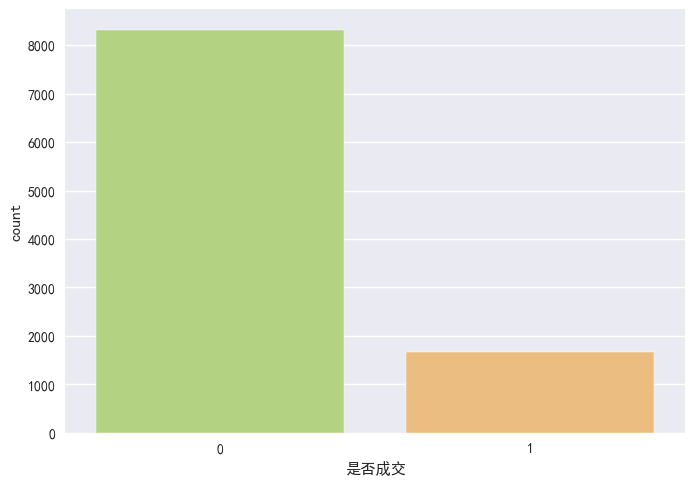

In [38]:
sns.countplot(x='是否成交',data=data,palette='RdYlGn_r')

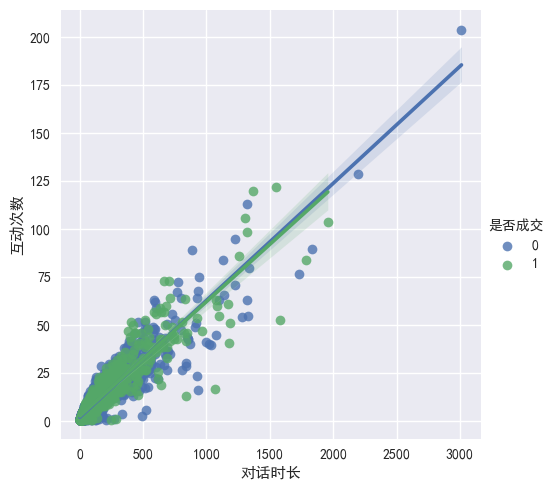

In [35]:
sns.lmplot(x="对话时长", y="互动次数", data=data, hue='是否成交')

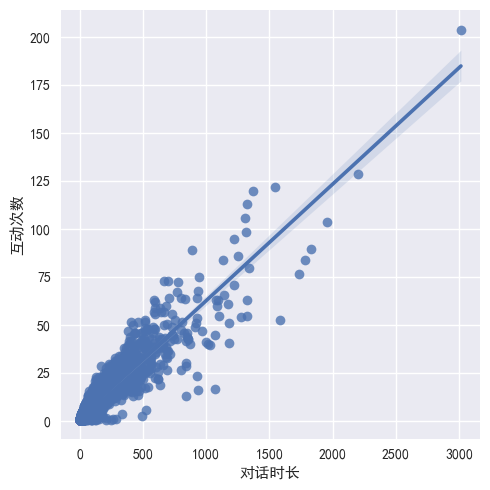

In [34]:
#回归图
sns.lmplot(x="对话时长", y="互动次数", data=data)

<AxesSubplot: xlabel='是否成交', ylabel='对话时长'>

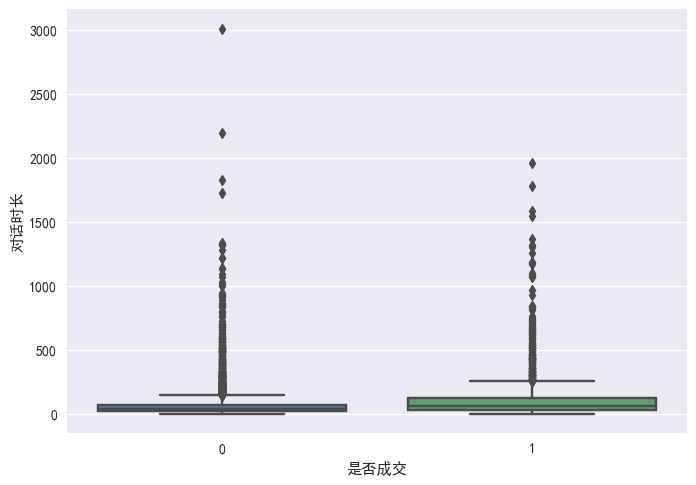

In [33]:
sns.boxplot(x="是否成交", y="对话时长", data=data)

<AxesSubplot: >

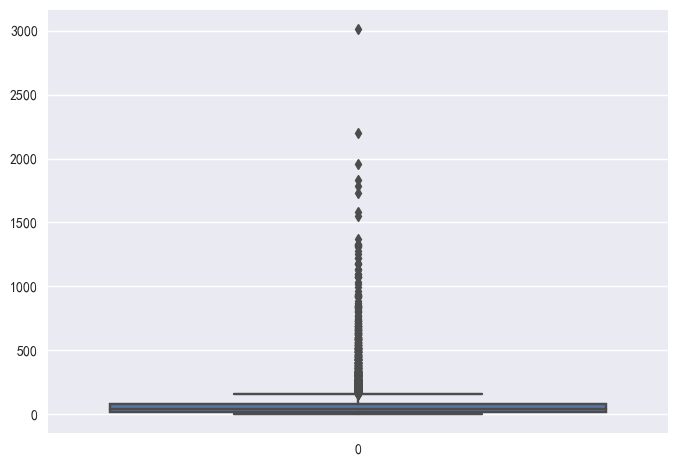

In [32]:
sns.boxplot(data=data['对话时长'])

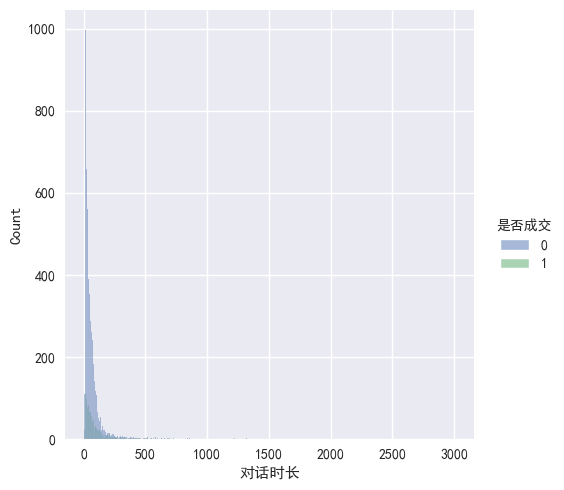

In [31]:
#分布图
sns.displot(data = data,x="对话时长", hue='是否成交')

<AxesSubplot: xlabel='对话时长', ylabel='互动次数'>

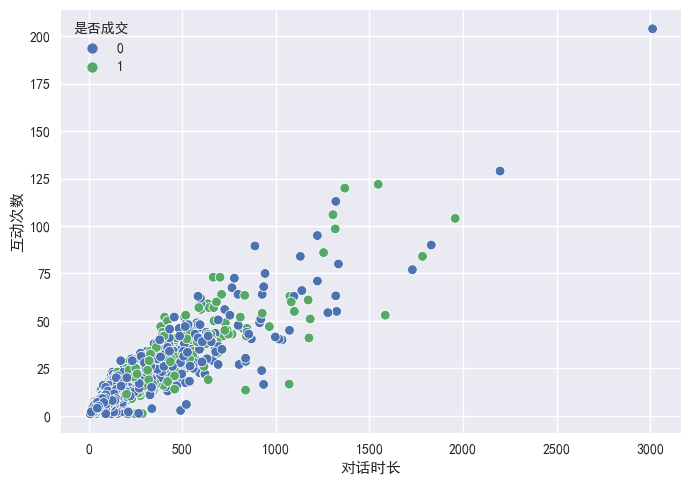

In [30]:
sns.scatterplot(data=data, x="对话时长", y="互动次数",hue='是否成交')
#散点图

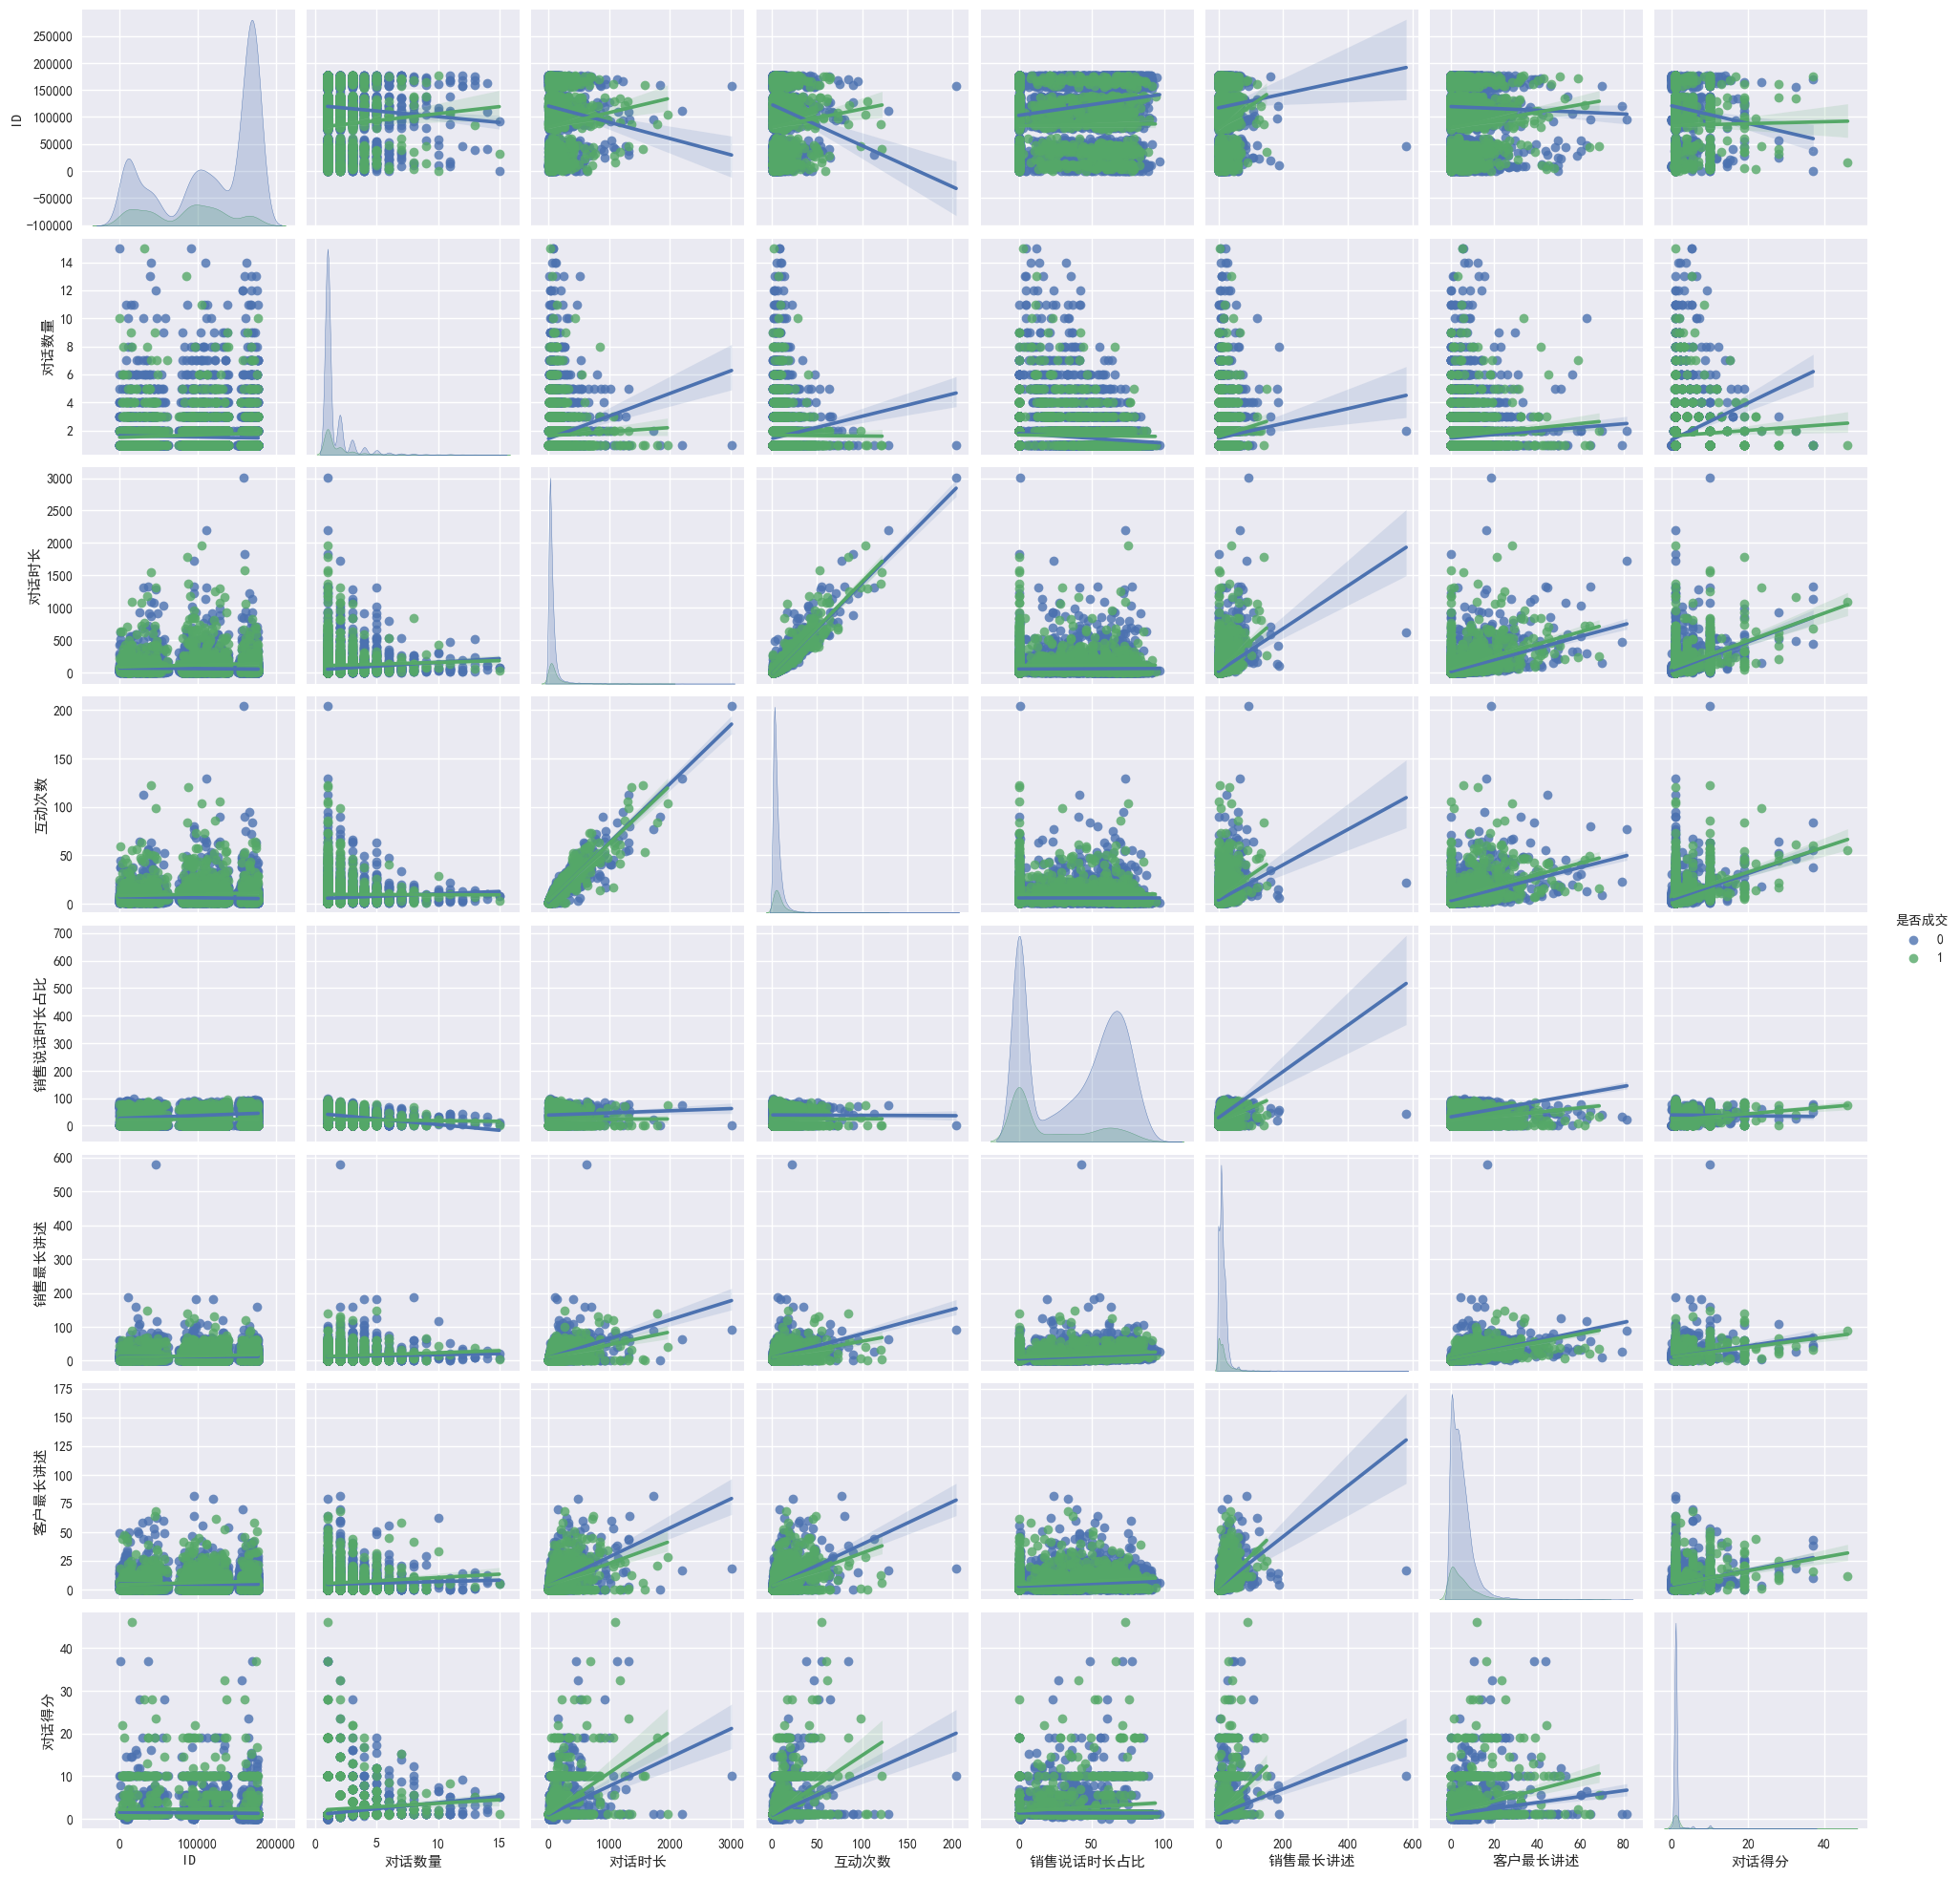

In [28]:
sns.pairplot(data,kind='reg',diag_kind='kde',hue='是否成交')

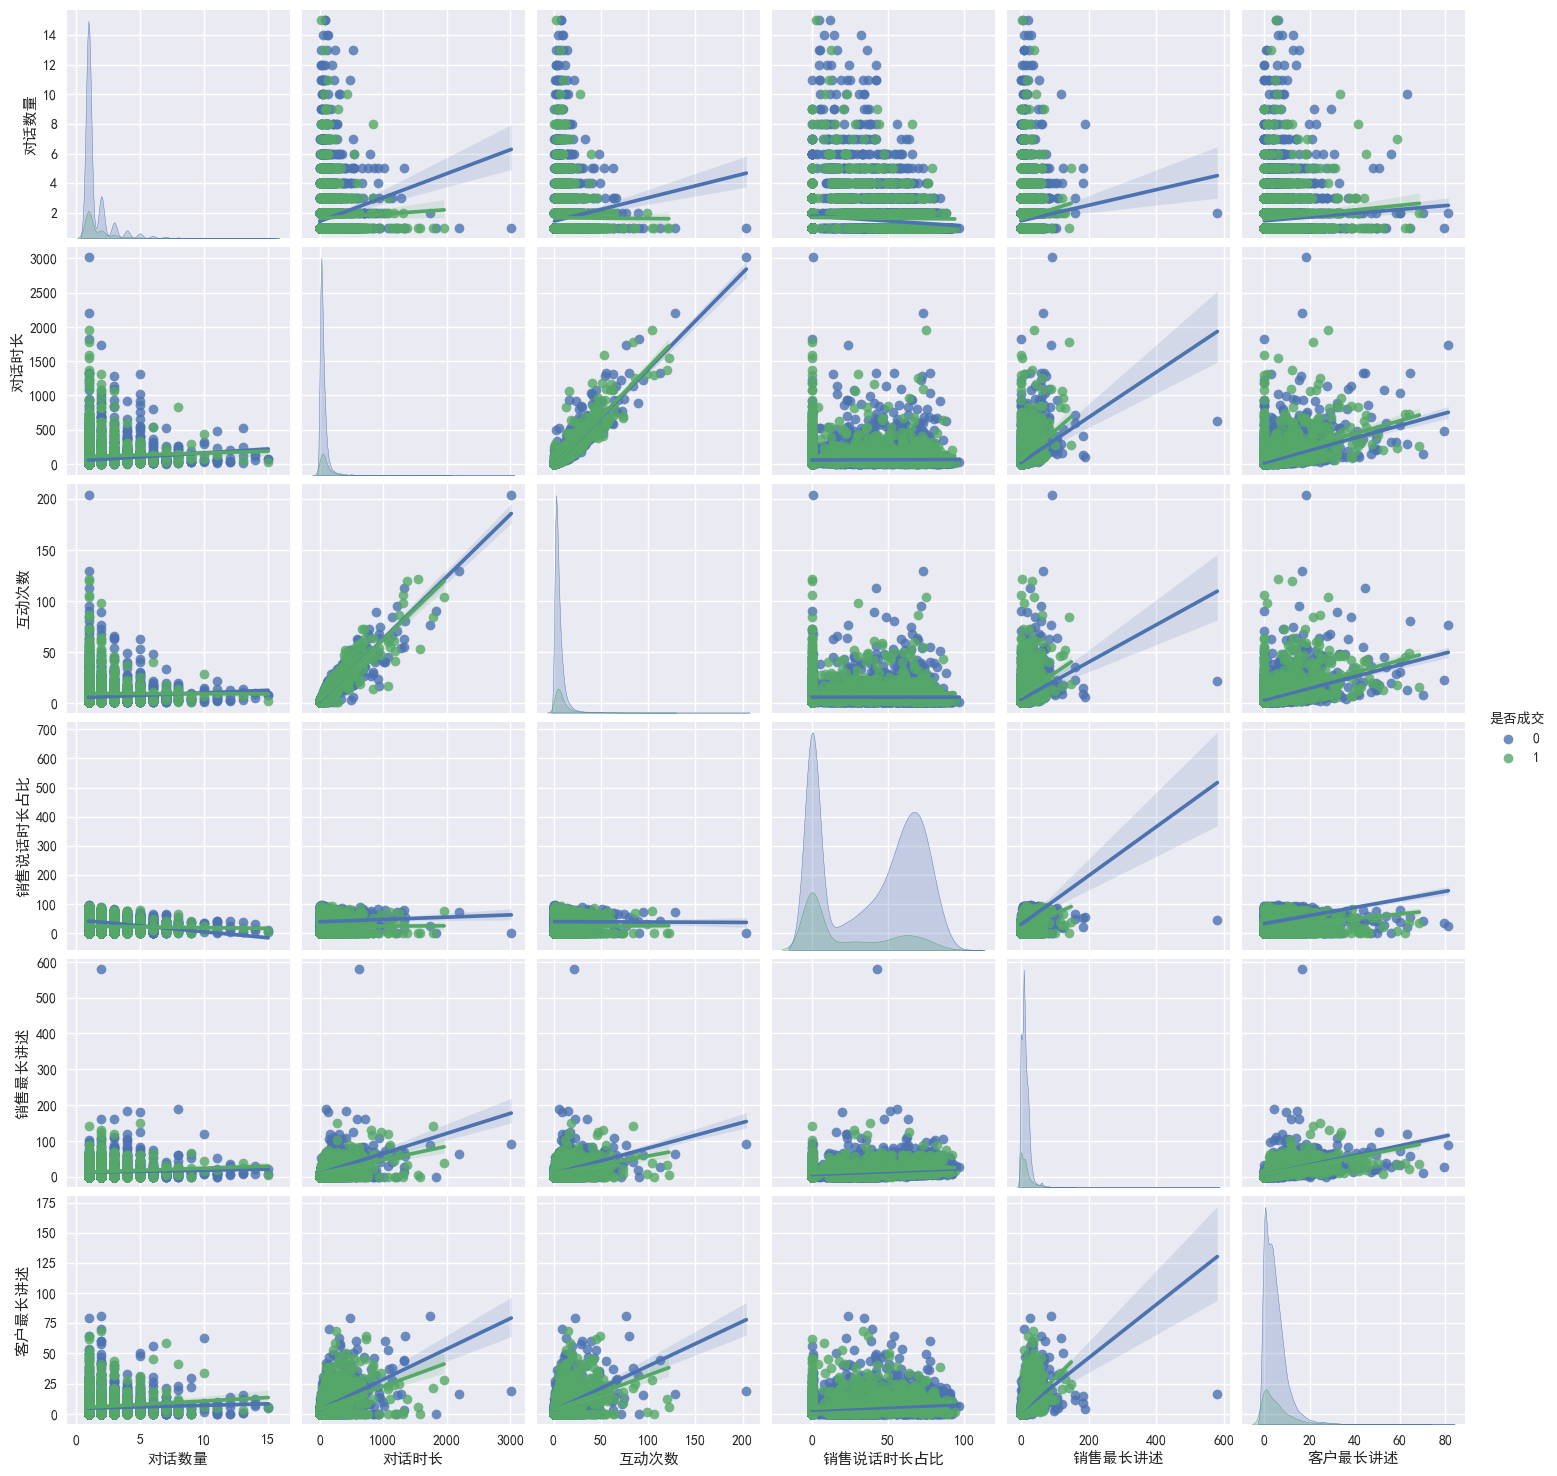

In [27]:
#描述性统计分析
#不同类别下，两两变量之间的关系
sns.pairplot(data[['对话数量', '对话时长', '互动次数', '销售说话时长占比', '销售最长讲述', '客户最长讲述','是否成交']], kind="reg",diag_kind="kde", hue='是否成交');

<AxesSubplot: >

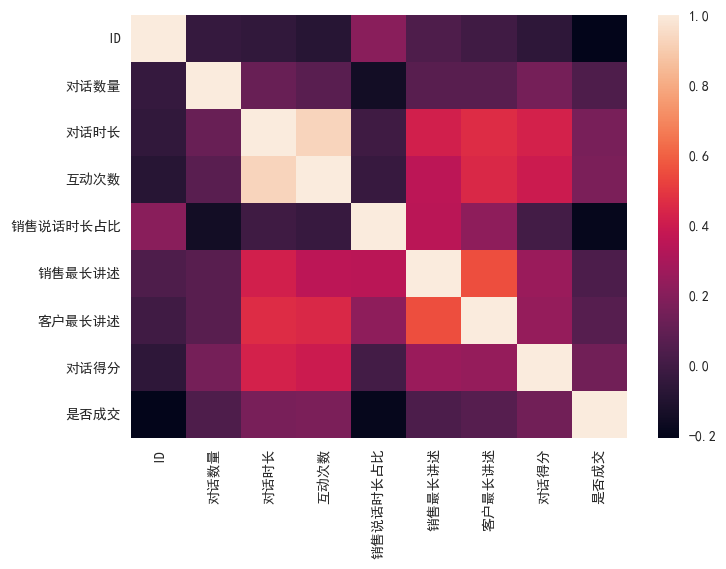

In [26]:
sns.heatmap(data.corr())

In [25]:
data.corr()

,ID,对话数量,对话时长,互动次数,销售说话时长占比,销售最长讲述,客户最长讲述,对话得分,是否成交
ID,1.000000,-0.035017,-0.052924,-0.084511,0.210827,0.039382,-0.004909,-0.060768,-0.209066
对话数量,-0.035017,1.000000,0.114307,0.069732,-0.148225,0.066501,0.067730,0.149951,0.040856
对话时长,-0.052924,0.114307,1.000000,0.925891,-0.010369,0.416713,0.463678,0.424580,0.160212
互动次数,-0.084511,0.069732,0.925891,1.000000,-0.033356,0.350818,0.447918,0.397499,0.170271
销售说话时长占比,0.210827,-0.148225,-0.010369,-0.033356,1.000000,0.345732,0.223492,0.004389,-0.193394
销售最长讲述,0.039382,0.066501,0.416713,0.350818,0.345732,1.000000,0.552494,0.254461,0.033712
客户最长讲述,-0.004909,0.067730,0.463678,0.447918,0.223492,0.552494,1.000000,0.240484,0.062235
对话得分,-0.060768,0.149951,0.424580,0.397499,0.004389,0.254461,0.240484,1.000000,0.144542
是否成交,-0.209066,0.040856,0.160212,0.170271,-0.193394,0.033712,0.062235,0.144542,1.000000


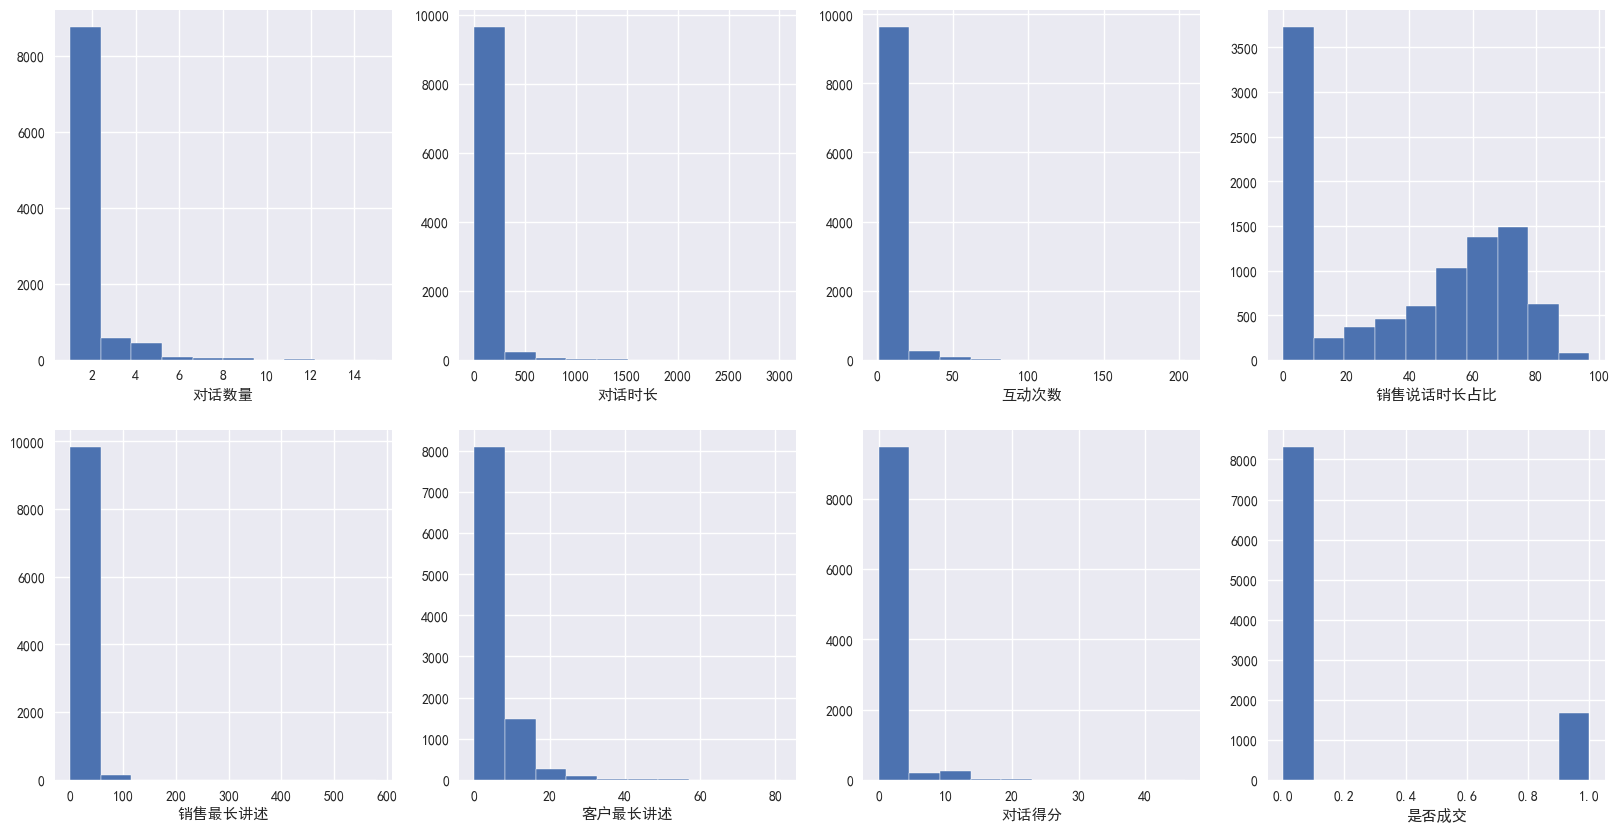

In [24]:
plt.figure(facecolor='white', figsize=(20,10))
plt.subplot(241)
plt.hist(data['对话数量'])
plt.xlabel('对话数量')

plt.subplot(242)
plt.hist(data['对话时长'])
plt.xlabel('对话时长')

plt.subplot(243)
plt.hist(data['互动次数'])
plt.xlabel('互动次数')

plt.subplot(244)
plt.hist(data['销售说话时长占比'])
plt.xlabel('销售说话时长占比')

plt.subplot(245)
plt.hist(data['销售最长讲述'])
plt.xlabel('销售最长讲述')

plt.subplot(246)
plt.hist(data['客户最长讲述'])
plt.xlabel('客户最长讲述')

plt.subplot(247)
plt.hist(data['对话得分'])
plt.xlabel('对话得分')

plt.subplot(248)
plt.hist(data['是否成交'])
plt.xlabel('是否成交');

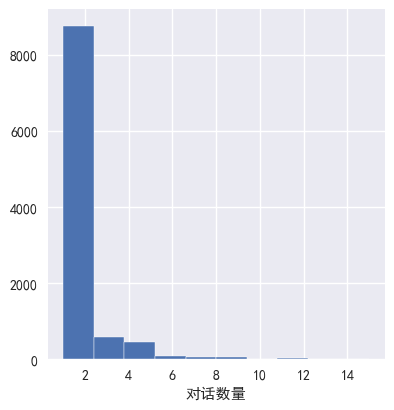

In [23]:
#异常值
plt.figure(facecolor='white', figsize=(20,10))
plt.subplot(241)
plt.hist(data['对话数量'])
plt.xlabel('对话数量');

In [20]:
#重复值
data.duplicated().mean()
data.drop_duplicates(inplace=True)

0.0

In [19]:
#数据探索
data.isnull().mean()

ID          0.0
对话数量        0.0
对话时长        0.0
互动次数        0.0
销售说话时长占比    0.0
销售最长讲述      0.0
客户最长讲述      0.0
对话得分        0.0
是否成交        0.0
dtype: float64

In [18]:
data.rename(columns={'客户ID':'ID', '对话时长(总时长/对话数量)':'对话时长', '互动次数(总次数/对话数量)':'互动次数',
                    '是否已成交(1已成交0未成交)':'是否成交'}, inplace=True)
data.head()

,ID,对话数量,对话时长,互动次数,销售说话时长占比,销售最长讲述,客户最长讲述,对话得分,是否成交
0,6,1,31.820,4.0,69.0,16.08,5.09,1.0,0
1,8,1,44.450,5.0,67.0,15.37,14.25,1.0,0
2,9,1,62.290,6.0,1.0,28.44,6.89,1.0,0
3,28,1,59.930,6.0,76.0,29.17,6.80,1.0,0
4,75,10,72.257,7.2,23.3,44.70,5.79,1.9,1


In [17]:
#‘成交意向度’为系统输出，这里不需要
data.drop('成交意向度', axis=1, inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   客户ID             10000 non-null  int64  
 1   对话数量             10000 non-null  int64  
 2   对话时长(总时长/对话数量)   10000 non-null  float64
 3   互动次数(总次数/对话数量)   10000 non-null  float64
 4   销售说话时长占比         10000 non-null  float64
 5   销售最长讲述           10000 non-null  float64
 6   客户最长讲述           10000 non-null  float64
 7   对话得分             10000 non-null  float64
 8   成交意向度            10000 non-null  float64
 9   是否已成交(1已成交0未成交)  10000 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 781.4 KB


In [15]:
data=pd.read_excel('客户列表.xls')
data.head()

,客户ID,对话数量,对话时长(总时长/对话数量),互动次数(总次数/对话数量),销售说话时长占比,销售最长讲述,客户最长讲述,对话得分,成交意向度,是否已成交(1已成交0未成交)
0,6,1,31.820,4.0,69.0,16.08,5.09,1.0,0.000,0
1,8,1,44.450,5.0,67.0,15.37,14.25,1.0,14.890,0
2,9,1,62.290,6.0,1.0,28.44,6.89,1.0,15.360,0
3,28,1,59.930,6.0,76.0,29.17,6.80,1.0,10.090,0
4,75,10,72.257,7.2,23.3,44.70,5.79,1.9,20.617,1


In [51]:
import statsmodels.formula.api as smf

In [11]:
os.chdir(r'C:\Users\fzh00\Desktop\文件\python资料\Python数据清洗基础\data\2_逻辑回归案例')

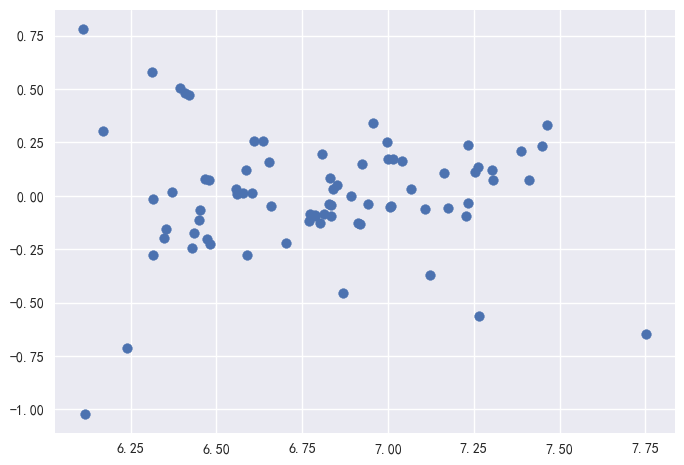

In [10]:
plt.scatter(model_3.predict(data),model_3.resid)
#残差图

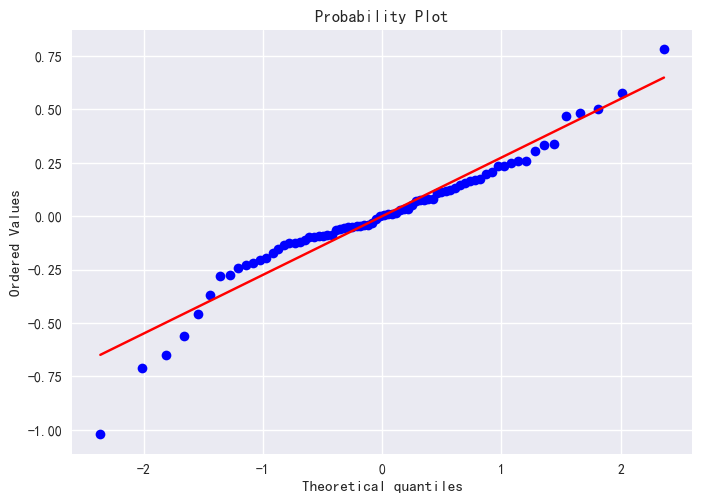

In [9]:
res2=stats.probplot(model_3.resid,plot=plt)

In [6]:
#公式 对因变量取对数后重新建模
formula3 = 'ln_avg_exp~gender+Age+Ownrent+Selfempl+dist_home_val+dist_avg_income+edu_1+edu_2+edu_3+edu_4'
#实例化
model_3 = ols(formula=formula3, data=data)
#拟合模型
model_3 = model_3.fit()
#输出拟合结果
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ln_avg_exp   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     11.02
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           1.07e-10
Time:                        18:58:57   Log-Likelihood:                -10.230
No. Observations:                  76   AIC:                             42.46
Df Residuals:                      65   BIC:                             68.10
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.5584      0.272     24.132      0.000       6.016       7.101
gender             -0.4043      0.117     -3.455      0.001      -0.638      -0.171
Age                 0.0023      0.006      0.401      0.689      -0.009       0.014
Ownrent             0.0783      0.091      0.864      0.391      -0.103       0.259
Selfempl            0.3503      0.154      2.269      0.027       0.042       0.659
dist_home_val      -0.0006      0.001     -0.581      0.564      -0.003       0.001
dist_avg_income     0.0714      0.020      3.613      0.001       0.032       0.111
edu_1              -0.1765      0.101     -1.756      0.084      -0.377       0.024
edu_2              -0.5436      0.112     -4.838      0.000      -0.768      -0.319
edu_3              -0.7403      0.190     -3.890      0.000      -1.120      -0.360
edu_4              -0.2004      0.358     -0.560      0.577      -0.915       0.514
==============================================================================
Omnibus:                       12.643   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               22.622
Skew:                          -0.559   Prob(JB):                     1.22e-05
Kurtosis:                       5.428   Cond. No.                         993.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
#因变量取对数
data['ln_avg_exp']=np.log(data['avg_exp'])
data.head()

,avg_exp,gender,Age,Ownrent,Selfempl,dist_home_val,dist_avg_income,edu_class,edu_1,edu_2,edu_3,edu_4,ln_avg_exp
0,1217.03,1,40.0,1,1,99.93,15.932789,0,0,0,0,0,7.104169
1,1251.50,1,32.0,1,0,49.88,15.796316,1,1,0,0,0,7.132098
2,856.57,1,41.0,1,0,16.10,11.275632,0,0,0,0,0,6.752936
3,1321.83,1,28.0,1,0,100.39,13.346474,1,1,0,0,0,7.186772
4,816.03,1,41.0,0,1,119.76,10.332263,0,0,0,0,0,6.704451


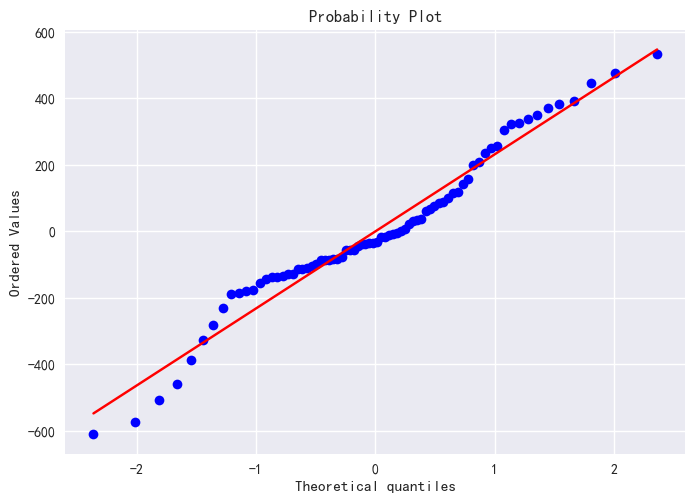

In [4]:
#正态性，有一点偏态，通过取对数，重新建议模型
res = stats.probplot(model_2.resid,plot=plt)

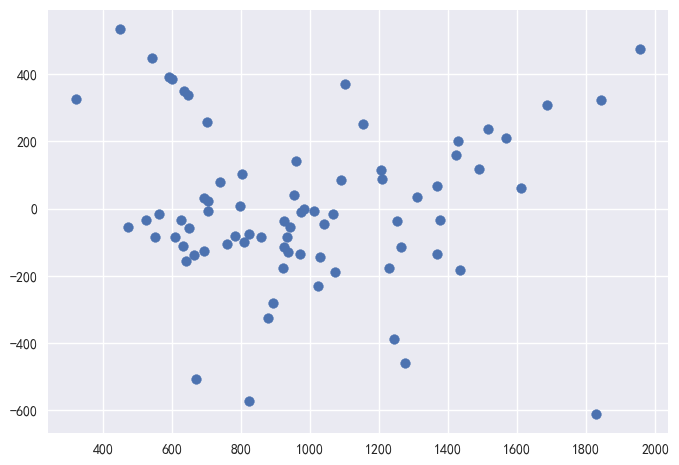

In [3]:
plt.scatter(model_2.predict(data),model_2.resid)
plt.show()
#如果出现非正态，对y取对数

C:\Users\fzh00\AppData\Local\Temp\ipykernel_3180\4125409144.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


0     False
1     False
2     False
3     False
4     False
      ...  
71    False
72    False
73    False
74    False
75    False
Length: 76, dtype: bool

0.0

,avg_exp,gender,Age,Income,Ownrent,Selfempl,dist_home_val,dist_avg_income,edu_class
0,1217.03,Male,40,16.03515,1,1,99.93,15.932789,研究生
1,1251.50,Male,32,15.84750,1,0,49.88,15.796316,大学
2,856.57,Male,41,11.47285,1,0,16.10,11.275632,研究生
3,1321.83,Male,28,13.40915,1,0,100.39,13.346474,大学
4,816.03,Male,41,10.03015,0,1,119.76,10.332263,研究生
...,...,...,...,...,...,...,...,...,...
71,491.04,Female,21,4.05520,0,0,36.81,4.349158,中学
72,468.61,Female,20,3.89305,0,0,66.75,4.551105,中学
73,593.92,Female,30,4.37960,0,0,124.23,5.040632,中学
74,418.78,Female,21,3.49390,0,0,34.46,3.828842,中学


avg_exp            0.078947
gender             0.000000
Age                0.000000
Income             0.000000
Ownrent            0.000000
Selfempl           0.000000
dist_home_val      0.000000
dist_avg_income    0.000000
edu_class          0.013158
dtype: float64

avg_exp            6
gender             0
Age                0
Income             0
Ownrent            0
Selfempl           0
dist_home_val      0
dist_avg_income    0
edu_class          1
dtype: int64

,avg_exp,gender,Age,Income,Ownrent,Selfempl,dist_home_val,dist_avg_income,edu_class
0,1217.03,Male,40,16.03515,1,1,99.93,15.932789,研究生
1,1251.50,Male,32,15.84750,1,0,49.88,15.796316,大学


0    56
1    20
Name: gender, dtype: int64

1

,avg_exp,gender,Age,Income,Ownrent,Selfempl,dist_home_val,dist_avg_income,edu_class
0,1217.03,1,40,16.03515,1,1,99.93,15.932789,0
1,1251.50,1,32,15.84750,1,0,49.88,15.796316,1


<AxesSubplot: >

pandas.core.series.Series

40    8.643062
Name: Age, dtype: float64

999

C:\Users\fzh00\AppData\Local\Temp\ipykernel_3180\4125409144.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['Age'].iloc[40]=data_raw['Age'].drop(index=40).mean()


,avg_exp,gender,Age,Income,Ownrent,Selfempl,dist_home_val,dist_avg_income,edu_class,edu_1,edu_2,edu_3,edu_4
avg_exp,1.000000e+00,0.203600,2.550378e-01,0.618998,0.296467,0.007544,0.299324,0.639808,-0.652473,-0.016009,-0.517608,-0.193775,-8.151683e-17
gender,2.035997e-01,1.000000,3.337694e-01,0.719685,0.430469,0.046657,0.190720,0.705310,-0.373224,0.126663,-0.291216,-0.158590,-6.900656e-02
Age,2.550378e-01,0.333769,1.000000e+00,0.320587,0.435519,0.097696,0.095233,0.310345,-0.305149,-0.020194,-0.258898,-0.061522,-4.190919e-17
Income,6.189981e-01,0.719685,3.205873e-01,1.000000,0.532525,-0.073450,0.271646,0.990413,-0.626842,0.033885,-0.356766,-0.300040,-1.535058e-01
Ownrent,2.964665e-01,0.430469,4.355194e-01,0.532525,1.000000,-0.115370,0.059849,0.512273,-0.328597,0.049609,-0.168620,-0.196988,-8.571429e-02
Selfempl,7.544430e-03,0.046657,9.769642e-02,-0.073450,-0.115370,1.000000,0.052527,-0.119567,0.236433,-0.192865,-0.101123,0.315952,3.944053e-01
dist_home_val,2.993244e-01,0.190720,9.523328e-02,0.271646,0.059849,0.052527,1.000000,0.286791,-0.311106,0.226996,-0.307158,-0.249559,1.443979e-01
dist_avg_income,6.398076e-01,0.705310,3.103451e-01,0.990413,0.512273,-0.119567,0.286791,1.000000,-0.648087,0.055505,-0.350248,-0.332764,-1.809021e-01
edu_class,-6.524726e-01,-0.373224,-3.051493e-01,-0.626842,-0.328597,0.236433,-0.311106,-0.648087,1.000000,-0.141865,0.565414,0.485764,3.294850e-01
edu_1,-1.600887e-02,0.126663,-2.019449e-02,0.033885,0.049609,-0.192865,0.226996,0.055505,-0.141865,1.000000,-0.461223,-0.174816,-7.606684e-02


,avg_exp,gender,Ownrent,Selfempl,edu_class
avg_exp,1.000000,0.167236,0.290705,0.064150,-0.561243
gender,0.167236,1.000000,0.430469,0.046657,-0.351901
Ownrent,0.290705,0.430469,1.000000,-0.115370,-0.300133
Selfempl,0.064150,0.046657,-0.115370,1.000000,0.154962
edu_class,-0.561243,-0.351901,-0.300133,0.154962,1.000000


,gender,Ownrent,Selfempl,edu_class
gender,1.000000,0.430469,0.046657,-0.380756
Ownrent,0.430469,1.000000,-0.115370,-0.324743
Selfempl,0.046657,-0.115370,1.000000,0.167669
edu_class,-0.380756,-0.324743,0.167669,1.000000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_exp   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     14.93
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           8.36e-14
Time:                        18:50:33   Log-Likelihood:                -519.52
No. Observations:                  76   AIC:                             1063.
Df Residuals:                      64   BIC:                             1091.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         535.9565    223.038      2.403      0.019      90.387     981.526
gender           -447.4828     97.100     -4.608      0.000    -641.463    -253.503
Age                 0.6121      4.779      0.128      0.898      -8.936      10.160
Income           -119.1929     72.411     -1.646      0.105    -263.850      25.464
Ownrent            41.3184     76.416      0.541      0.591    -111.341     193.977
Selfempl          153.7000    129.424      1.188      0.239    -104.853     412.253
dist_home_val       0.1579      0.859      0.184      0.855      -1.557       1.873
dist_avg_income   211.5250     71.122      2.974      0.004      69.442     353.608
edu_1            -262.5083     82.890     -3.167      0.002    -428.100     -96.916
edu_2            -495.1400     92.266     -5.366      0.000    -679.462    -310.818
edu_3            -292.5211    156.617     -1.868      0.066    -605.400      20.358
edu_4              49.3783    294.618      0.168      0.867    -539.188     637.945
==============================================================================
Omnibus:                        0.894   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.640   Jarque-Bera (JB):                0.613
Skew:                          -0.219   Prob(JB):                        0.736
Kurtosis:                       3.044   Cond. No.                     1.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_is_nested',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'info_c

0    -565.630770
1     -95.652529
2    -318.456003
3     196.720056
4    -460.157387
         ...    
71     -5.047028
72    -93.635981
73    -29.075904
74    -33.779180
75   -494.515263
Length: 76, dtype: float64

,gender,Age,Income,Ownrent,Selfempl,dist_home_val,dist_avg_income,edu_class,edu_1,edu_2,edu_3,edu_4,Inter
0,1,40.0,16.03515,1,1,99.93,15.932789,0,0,0,0,0,1
1,1,32.0,15.84750,1,0,49.88,15.796316,1,1,0,0,0,1


,gender,Age,Income,Ownrent,Selfempl,dist_home_val,dist_avg_income,edu_class,Inter
0,1,40.0,16.03515,1,1,99.93,15.932789,0,1
1,1,32.0,15.84750,1,0,49.88,15.796316,1,1


64.76239230667133

gender 2.2091919746839945
Age 1.3708810657506334
Income 64.76239230667133
Ownrent 1.6682817716496416
Selfempl 1.2887640187408764
dist_home_val 1.165431243043153
dist_avg_income 64.13992249399887
edu_class 1.994586770890881
Inter 59.346326941669986


,avg_exp,gender,Age,Ownrent,Selfempl,dist_home_val,dist_avg_income,edu_class,edu_1,edu_2,edu_3,edu_4
0,1217.03,1,40.0,1,1,99.93,15.932789,0,0,0,0,0
1,1251.50,1,32.0,1,0,49.88,15.796316,1,1,0,0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_exp   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     15.74
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           7.14e-14
Time:                        18:50:33   Log-Likelihood:                -521.10
No. Observations:                  76   AIC:                             1064.
Df Residuals:                      65   BIC:                             1090.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         553.7869    225.685      2.454      0.017     103.062    1004.511
gender           -472.4592     97.160     -4.863      0.000    -666.502    -278.416
Age                 1.1111      4.832      0.230      0.819      -8.539      10.761
Ownrent            11.9649     75.277      0.159      0.874    -138.374     162.304
Selfempl          108.9822    128.194      0.850      0.398    -147.038     365.002
dist_home_val       0.2724      0.867      0.314      0.754      -1.459       2.004
dist_avg_income    97.5291     16.408      5.944      0.000      64.761     130.297
edu_1            -247.4391     83.459     -2.965      0.004    -414.119     -80.759
edu_2            -486.1425     93.307     -5.210      0.000    -672.489    -299.796
edu_3            -315.3806    158.038     -1.996      0.050    -631.005       0.244
edu_4               3.8444    297.148      0.013      0.990    -589.602     597.291
==============================================================================
Omnibus:                        1.093   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.579   Jarque-Bera (JB):                0.521
Skew:                          -0.056   Prob(JB):                        0.771
Kurtosis:                       3.390   Cond. No.                         993.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

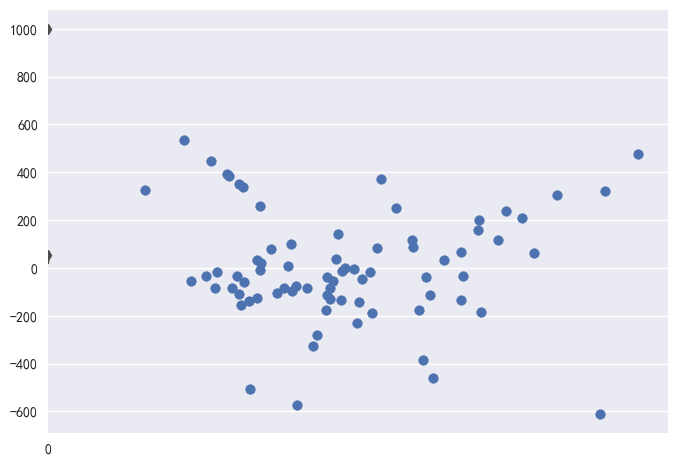

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#设置字体为黑色
plt.rcParams['font.family']='SimHei'
#显示符号
plt.rcParams['axes.unicode_minus']= False

from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

#读取数据
import os
os.chdir(r'C:\Users\fzh00\Desktop\文件\python资料\Python数据清洗基础\data\1_线性回归案例')
data_raw = pd.read_excel('LR_practice.xlsx')


data_raw.drop(['id','Acc','edad2'],axis=1,inplace=True)

#删除重复值
data_raw.duplicated() #查看是否有重复值
data_raw.duplicated().mean() #查看重复值的比例
#删除重复值
data_raw.drop_duplicates()
data_raw.isnull().mean()
data_raw.isnull().sum()
#填补缺失值 ,用均值填补
data_raw['avg_exp'].fillna(data_raw['avg_exp'].mean(),inplace=True)
#数据编码和缺失值
data_raw.head(2)
data_raw['gender']=data_raw['gender'].map({'Male':1,'Female':0})
data_raw['gender'].value_counts()
label = data_raw['edu_class'].unique().tolist()
label.index('大学')
data_raw['edu_class']=data_raw['edu_class'].apply(lambda x: label.index(x))
data_raw.head(2)
import seaborn as sns
sns.boxplot(data_raw['Age'])
#3位标准准差
from scipy import stats
#标准化Age,如果有大于3或小于-3则认为是异常数据
z=stats.zscore(data_raw['Age'])
type(z)
#寻找异常数据对应的索引
z[(z>3)|(z<-3)]  #找到一个 40    8.643062
#查看原始的异常数据
data_raw['Age'].iloc[40]  #原始数据是999
#用均填补
data_raw['Age'].iloc[40]=data_raw['Age'].drop(index=40).mean()

#哑变量的转换
dummy=pd.get_dummies(data_raw['edu_class'],prefix='edu',drop_first=True)
data=pd.concat([data_raw,dummy],axis=1)

#相关分析前进行异常值处理
data.corr()
#查看分类变量相关系数
data[['avg_exp','gender','Ownrent','Selfempl','edu_class']].corr(method='kendall')
data[['gender','Ownrent','Selfempl','edu_class']].corr(method='spearman')
#热地图
# sns.heatmap(data.corr(),annot=True)
# sns.heatmap(data.corr())
# plt.show()
# #散点图
# plt.scatter(data['avg_exp'],data['Income'])
# plt.show()
# data.corr()

#建立模型过程

#公式
formula = 'avg_exp~gender+Age+Income+Ownrent+Selfempl+dist_home_val+dist_avg_income+edu_1+edu_2+edu_3+edu_4'
#实例化
model = ols(formula=formula, data=data)
#拟合模型
model = model.fit()
#输出拟合结果
model.summary()
#常用接口
dir(model)
model.resid  #残差
#模型调优
#共线性
#手动去除因变量
data_vif=data.drop(['avg_exp'],axis=1)
#手动添加截距项
data_vif['Inter']=1
data_vif.head(2)
data_vif.drop(['edu_1','edu_2','edu_3','edu_4'],axis=1,inplace=True)
data_vif.head(2)
#查看单个变量的VIF
vif(data_vif,2)  #看下第2个变量（Income)的vif值 1--3正常，3-10可用岭回归,>10不可用
for i in range(0,data_vif.shape[1]):
  print(data_vif.columns[i],vif(data_vif,i))

#去掉共线性高的变量
data.drop('Income',axis=1,inplace=True)
data.head(2)
#重新拟合
#公式
formula2 = 'avg_exp~gender+Age+Ownrent+Selfempl+dist_home_val+dist_avg_income+edu_1+edu_2+edu_3+edu_4'
#实例化
model_2 = ols(formula=formula2, data=data)
#拟合模型
model_2 = model_2.fit()
#输出拟合结果
model_2.summary()
#同方差
#一元：横轴为自变量，纵轴为残差
#多元：横轴为拟合值 model.predict(data)，纵轴为残差

plt.scatter(model_2.predict(data),model_2.resid)
plt.show()



In [11]:
#一键输出分析报告
import pandas_profiling as pp
report = pp.ProfileReport(data_raw)
report.to_file('report1114.html')
#输出 到notebook
#report .to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\multimethod\__init__.py:209: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  return self[tuple(map(self.get_type, args))](*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\pandas_profiling\visualisation\utils.py:73: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  plt.savefig(
C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\pandas_profiling\visualisation\utils.py:73: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  plt.savefig(
C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\pandas_profiling\visualisation\utils.py:73: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  plt.savefig(
C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\pandas_profiling\visualisation\utils.py:73: UserWarning: Glyph 30740 (\N{CJK UNIFIED IDEOGRAPH-7814}) missing from current font.
  plt.savefig(
C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\pandas_profiling\visualisation\utils.py:73: UserWarning: Glyph 31350 

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
os.getcwd()

'C:\\Users\\fzh00\\Desktop\\文件\\python资料\\Python数据清洗基础\\data\\1_线性回归案例'

In [3]:
#读取数据
import os
os.chdir(r'C:\Users\fzh00\Desktop\文件\python资料\Python数据清洗基础\data\1_线性回归案例')
data_raw = pd.read_excel('LR_practice.xlsx')
data_raw.head()

,id,Acc,avg_exp,gender,Age,Income,Ownrent,Selfempl,dist_home_val,dist_avg_income,edad2,edu_class
0,19,1,1217.03,Male,40,16.03515,1,1,99.93,15.932789,1600,研究生
1,5,1,1251.50,Male,32,15.84750,1,0,49.88,15.796316,1024,大学
2,86,1,856.57,Male,41,11.47285,1,0,16.10,11.275632,1681,研究生
3,50,1,1321.83,Male,28,13.40915,1,0,100.39,13.346474,784,大学
4,67,1,816.03,Male,41,10.03015,0,1,119.76,10.332263,1681,研究生


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif


In [31]:
continuous_xclos
lcv.coef_
#相当于年龄和收入无关，支出仅和房屋和平均收入有关

['Age', 'Income', 'dist_home_val', 'dist_avg_income']

array([0.        , 0.        , 0.02789489, 0.26549855])

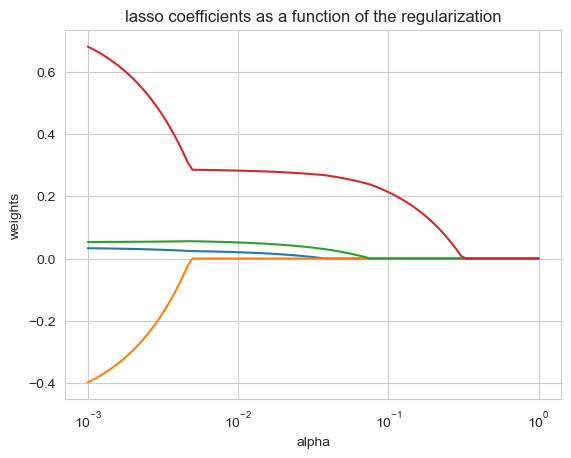

In [33]:
lasso_coefs=[]
for alpha in lasso_alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(X,y)
    lasso_coefs.append(lasso.coef_);
ax=plt.gca()
ax.plot(lasso_alphas,lasso_coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show();

In [32]:
lasso_coefs=[]


In [23]:
#Lasso回归正则化
from sklearn.linear_model import Lasso
#交叉 验证
from sklearn.linear_model import LassoCV
lasso=Lasso()
lasso_alphas=np.logspace(-3,0,100,base=10)
lcv=LassoCV(alphas=lasso_alphas,cv=10)#serch the min mse by cv
lcv.fit(X,y)
print("the best alpha is{}".format(lcv.alpha_))
print("the r-square is {}".format(lcv.score(X,y)))
# lasso_coefs=[]
# for alpha in lasso_alphas:
#     lasso.set_params(alpha=alpha)
#     lasso.fit(X,y)
#     lasso_coefs.append(lasso.coef_)


LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
        cv=10)

the best alpha is0.04037017258596556
the r-square is 0.44264510698622317


In [22]:
ridge.set_params(alpha=40)
ridge.fit(X,y)
continuous_xclos
ridge.coef_
#对于这个模型 拿来预测
np.exp(ridge.predict(X_new))

Ridge(alpha=40)

Ridge(alpha=40)

['Age', 'Income', 'dist_home_val', 'dist_avg_income']

array([0.03293109, 0.09907747, 0.04976305, 0.12101456])

array([905.2624672 , 725.46211366, 683.86109047, 745.14494083,
       708.39244221, 725.54335876, 619.25021182, 687.49797753,
       659.42475183, 682.96634192, 681.9105569 , 619.62470846,
       614.88672658, 553.6438683 , 681.20469079, 684.41996051,
       612.34259511, 586.1842537 , 612.58811939, 635.43241033,
       607.8191964 , 533.58278446, 675.99706729, 631.96205158,
       574.77227171, 672.43050654, 582.31413707, 605.47161674,
       549.04419695, 616.29846152])

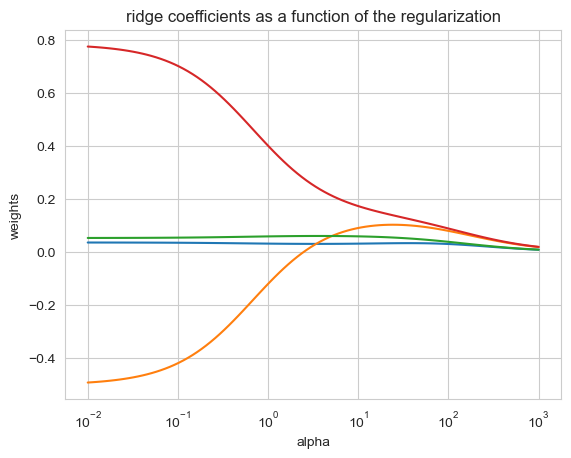

In [17]:
 #绘制正则参数-回归系数图形
ax=plt.gca()
ax.plot(alphas,coefs)
ax.set_xscale("log")#设置x轴对数坐标
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show();

In [15]:
#使用岭迹图，手动选择，用不同的正则参数，生成一系列岭回归的模型
from sklearn.linear_model import Ridge
ridge = Ridge()
#生成很多个岭回归模型，
coefs = []
for alpha in alphas:
    ridge.set_params(alpha=alpha)
    ridge.fit(X,y)
    coefs.append(ridge.coef_)

Ridge(alpha=0.01)

Ridge(alpha=0.01)

Ridge(alpha=0.011233240329780276)

Ridge(alpha=0.011233240329780276)

Ridge(alpha=0.012618568830660204)

Ridge(alpha=0.012618568830660204)

Ridge(alpha=0.014174741629268055)

Ridge(alpha=0.014174741629268055)

Ridge(alpha=0.015922827933410922)

Ridge(alpha=0.015922827933410922)

Ridge(alpha=0.01788649529057435)

Ridge(alpha=0.01788649529057435)

Ridge(alpha=0.02009233002565047)

Ridge(alpha=0.02009233002565047)

Ridge(alpha=0.022570197196339202)

Ridge(alpha=0.022570197196339202)

Ridge(alpha=0.025353644939701114)

Ridge(alpha=0.025353644939701114)

Ridge(alpha=0.02848035868435802)

Ridge(alpha=0.02848035868435802)

Ridge(alpha=0.03199267137797385)

Ridge(alpha=0.03199267137797385)

Ridge(alpha=0.03593813663804628)

Ridge(alpha=0.03593813663804628)

Ridge(alpha=0.040370172585965536)

Ridge(alpha=0.040370172585965536)

Ridge(alpha=0.04534878508128582)

Ridge(alpha=0.04534878508128582)

Ridge(alpha=0.0509413801481638)

Ridge(alpha=0.0509413801481638)

Ridge(alpha=0.05722367659350217)

Ridge(alpha=0.05722367659350217)

Ridge(alpha=0.06428073117284319)

Ridge(alpha=0.06428073117284319)

Ridge(alpha=0.07220809018385464)

Ridge(alpha=0.07220809018385464)

Ridge(alpha=0.08111308307896872)

Ridge(alpha=0.08111308307896872)

Ridge(alpha=0.09111627561154892)

Ridge(alpha=0.09111627561154892)

Ridge(alpha=0.10235310218990264)

Ridge(alpha=0.10235310218990264)

Ridge(alpha=0.11497569953977356)

Ridge(alpha=0.11497569953977356)

Ridge(alpha=0.1291549665014884)

Ridge(alpha=0.1291549665014884)

Ridge(alpha=0.14508287784959395)

Ridge(alpha=0.14508287784959395)

Ridge(alpha=0.16297508346206444)

Ridge(alpha=0.16297508346206444)

Ridge(alpha=0.18307382802953678)

Ridge(alpha=0.18307382802953678)

Ridge(alpha=0.20565123083486514)

Ridge(alpha=0.20565123083486514)

Ridge(alpha=0.23101297000831592)

Ridge(alpha=0.23101297000831592)

Ridge(alpha=0.25950242113997357)

Ridge(alpha=0.25950242113997357)

Ridge(alpha=0.2915053062825176)

Ridge(alpha=0.2915053062825176)

Ridge(alpha=0.32745491628777285)

Ridge(alpha=0.32745491628777285)

Ridge(alpha=0.36783797718286326)

Ridge(alpha=0.36783797718286326)

Ridge(alpha=0.41320124001153363)

Ridge(alpha=0.41320124001153363)

Ridge(alpha=0.464158883361278)

Ridge(alpha=0.464158883361278)

Ridge(alpha=0.5214008287999684)

Ridge(alpha=0.5214008287999684)

Ridge(alpha=0.5857020818056667)

Ridge(alpha=0.5857020818056667)

Ridge(alpha=0.6579332246575679)

Ridge(alpha=0.6579332246575679)

Ridge(alpha=0.739072203352578)

Ridge(alpha=0.739072203352578)

Ridge(alpha=0.8302175681319743)

Ridge(alpha=0.8302175681319743)

Ridge(alpha=0.9326033468832199)

Ridge(alpha=0.9326033468832199)

Ridge(alpha=1.0476157527896652)

Ridge(alpha=1.0476157527896652)

Ridge(alpha=1.1768119524349978)

Ridge(alpha=1.1768119524349978)

Ridge(alpha=1.3219411484660286)

Ridge(alpha=1.3219411484660286)

Ridge(alpha=1.484968262254465)

Ridge(alpha=1.484968262254465)

Ridge(alpha=1.6681005372000592)

Ridge(alpha=1.6681005372000592)

Ridge(alpha=1.873817422860383)

Ridge(alpha=1.873817422860383)

Ridge(alpha=2.1049041445120196)

Ridge(alpha=2.1049041445120196)

Ridge(alpha=2.364489412645407)

Ridge(alpha=2.364489412645407)

Ridge(alpha=2.656087782946687)

Ridge(alpha=2.656087782946687)

Ridge(alpha=2.9836472402833403)

Ridge(alpha=2.9836472402833403)

Ridge(alpha=3.351602650938841)

Ridge(alpha=3.351602650938841)

Ridge(alpha=3.7649358067924674)

Ridge(alpha=3.7649358067924674)

Ridge(alpha=4.229242874389499)

Ridge(alpha=4.229242874389499)

Ridge(alpha=4.750810162102798)

Ridge(alpha=4.750810162102798)

Ridge(alpha=5.336699231206307)

Ridge(alpha=5.336699231206307)

Ridge(alpha=5.994842503189409)

Ridge(alpha=5.994842503189409)

Ridge(alpha=6.7341506577508214)

Ridge(alpha=6.7341506577508214)

Ridge(alpha=7.56463327554629)

Ridge(alpha=7.56463327554629)

Ridge(alpha=8.497534359086439)

Ridge(alpha=8.497534359086439)

Ridge(alpha=9.545484566618338)

Ridge(alpha=9.545484566618338)

Ridge(alpha=10.722672220103231)

Ridge(alpha=10.722672220103231)

Ridge(alpha=12.045035402587823)

Ridge(alpha=12.045035402587823)

Ridge(alpha=13.530477745798061)

Ridge(alpha=13.530477745798061)

Ridge(alpha=15.199110829529332)

Ridge(alpha=15.199110829529332)

Ridge(alpha=17.073526474706906)

Ridge(alpha=17.073526474706906)

Ridge(alpha=19.179102616724887)

Ridge(alpha=19.179102616724887)

Ridge(alpha=21.544346900318846)

Ridge(alpha=21.544346900318846)

Ridge(alpha=24.20128264794381)

Ridge(alpha=24.20128264794381)

Ridge(alpha=27.1858824273294)

Ridge(alpha=27.1858824273294)

Ridge(alpha=30.538555088334157)

Ridge(alpha=30.538555088334157)

Ridge(alpha=34.30469286314919)

Ridge(alpha=34.30469286314919)

Ridge(alpha=38.53528593710527)

Ridge(alpha=38.53528593710527)

Ridge(alpha=43.28761281083057)

Ridge(alpha=43.28761281083057)

Ridge(alpha=48.62601580065353)

Ridge(alpha=48.62601580065353)

Ridge(alpha=54.62277217684343)

Ridge(alpha=54.62277217684343)

Ridge(alpha=61.35907273413169)

Ridge(alpha=61.35907273413169)

Ridge(alpha=68.92612104349695)

Ridge(alpha=68.92612104349695)

Ridge(alpha=77.4263682681127)

Ridge(alpha=77.4263682681127)

Ridge(alpha=86.97490026177834)

Ridge(alpha=86.97490026177834)

Ridge(alpha=97.70099572992247)

Ridge(alpha=97.70099572992247)

Ridge(alpha=109.74987654930568)

Ridge(alpha=109.74987654930568)

Ridge(alpha=123.28467394420659)

Ridge(alpha=123.28467394420659)

Ridge(alpha=138.48863713938718)

Ridge(alpha=138.48863713938718)

Ridge(alpha=155.56761439304722)

Ridge(alpha=155.56761439304722)

Ridge(alpha=174.7528400007683)

Ridge(alpha=174.7528400007683)

Ridge(alpha=196.30406500402725)

Ridge(alpha=196.30406500402725)

Ridge(alpha=220.51307399030458)

Ridge(alpha=220.51307399030458)

Ridge(alpha=247.70763559917089)

Ridge(alpha=247.70763559917089)

Ridge(alpha=278.2559402207126)

Ridge(alpha=278.2559402207126)

Ridge(alpha=312.5715849688235)

Ridge(alpha=312.5715849688235)

Ridge(alpha=351.11917342151276)

Ridge(alpha=351.11917342151276)

Ridge(alpha=394.4206059437656)

Ridge(alpha=394.4206059437656)

Ridge(alpha=443.06214575838777)

Ridge(alpha=443.06214575838777)

Ridge(alpha=497.7023564332114)

Ridge(alpha=497.7023564332114)

Ridge(alpha=559.0810182512223)

Ridge(alpha=559.0810182512223)

Ridge(alpha=628.0291441834247)

Ridge(alpha=628.0291441834247)

Ridge(alpha=705.4802310718645)

Ridge(alpha=705.4802310718645)

Ridge(alpha=792.482898353917)

Ridge(alpha=792.482898353917)

Ridge(alpha=890.2150854450392)

Ridge(alpha=890.2150854450392)

Ridge(alpha=1000.0)

Ridge(alpha=1000.0)

In [12]:
#看下系数
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
continuous_xclos
rcv.coef_
#收入与支出成反比 ，不太合理，需要调整

['Age', 'Income', 'dist_home_val', 'dist_avg_income']

array([ 0.03321449, -0.30956185,  0.05551208,  0.59067449])

In [8]:
#预测
X_new=scaler.transform(oos_data[continuous_xclos])
np.exp(rcv.predict(X_new))[:5]

array([839.81287306, 611.05788637, 723.58817458, 722.42039681,
       644.32489575])

In [5]:
print("the best alpha is {}".format(rcv.alpha_))
print("the r-square is {}".format(rcv.score(X,y)))


the best alpha is 0.2915053062825176
the r-square is 0.4756826777019494


In [4]:
#我们使用不同的正则化系数对模型进行交叉验证
from sklearn.linear_model import RidgeCV
alphas=np.logspace(-2,3,100,base=10)#正则化系数的搜索空间
rcv=RidgeCV(alphas=alphas,store_cv_values=True)
rcv.fit(X,y)

RidgeCV(alphas=array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.53487851e-02, 5.09413801e-02, 5.72236766e-02,
       6.42807312e-02, 7.22080902e-02, 8.11130831e-02, 9.11162756e-02,
       1.02353102e-01, 1.14975700e-0...
       6.89261210e+01, 7.74263683e+01, 8.69749003e+01, 9.77009957e+01,
       1.09749877e+02, 1.23284674e+02, 1.38488637e+02, 1.55567614e+02,
       1.74752840e+02, 1.96304065e+02, 2.20513074e+02, 2.47707636e+02,
       2.78255940e+02, 3.12571585e+02, 3.51119173e+02, 3.94420606e+02,
       4.43062146e+02, 4.97702356e+02, 5.59081018e+02, 6.28029144e+02,
       7.05480231e+02, 7.92482898e+02, 8.90215085e+02, 1.00000000e+03]),
        store_cv_values=True)

In [3]:
#标准化
from sklearn.preprocessing import StandardScaler
continuous_xclos=["Age","Income","dist_home_val","dist_avg_income"]#抽取连续变量
scaler=StandardScaler()
X=scaler.fit_transform(train[continuous_xclos])
y=train["avg_exp_ln"]

In [2]:
import os
os.__file__
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
os.chdir(r'C:\Data\Jupyter_file\机器学习')
#只显示8列
pd.set_option('display.max_columns',8)
raw_data=pd.read_csv('creditcard_exp.csv',skipinitialspace=True)
raw_data.head()
#id:客户id，ACC:是否开卡; avg_exp: 月均支出 avg_exp_ln:求了对数
#ownrent:是否有房室; selfmpl；是否自谋职业，
out_of_sample=pd.read_csv('creditcard_exp_out_of_sample.csv',skipinitialspace=True)
#找出支出不为空的数据
train=raw_data[raw_data['avg_exp'].notnull()].copy().iloc[:,2:].drop('age2',axis=1)
train.head()
oos_data=out_of_sample.copy().drop('age2',axis=1)
#正则化，ridge ，岭回归,前面需要去量刚，即数据标准化
#标准化
from sklearn.preprocessing import StandardScaler

In [16]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

plt.rcParams['axes.unicode_minus']=False#显示负号\n",
plt.figure(figsize=(6,4))## 设置画布\n"

import numpy as np
x_norm1=np.random.randn(1000)
x_norm2=2+np.random.randn(1000)
x_norm3=4+np.random.randn(1000)
plt.figure(figsize=(6,4))## 设置画布\n",
plt.hist(x_norm1,bins=50,density=True,color='r')
plt.hist(x_norm2,bins=50,density=True,color='g')
plt.hist(x_norm3,bins=50,density=True,color='b')
plt.show()

C:\Users\fzh00\AppData\Local\Temp\ipykernel_12080\468051068.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

(array([0.00762185, 0.        , 0.        , 0.        , 0.00762185,
        0.02286556, 0.02286556, 0.03048742, 0.07621855, 0.06859669,
        0.03810927, 0.09908411, 0.16005895, 0.19816822, 0.22103378,
        0.20579007, 0.30487418, 0.20579007, 0.22865564, 0.35822716,
        0.40395829, 0.34298345, 0.42682385, 0.36584902, 0.32011789,
        0.35822716, 0.35822716, 0.31249604, 0.25914305, 0.43444571,
        0.34298345, 0.2515212 , 0.22103378, 0.16005895, 0.13719338,
        0.15243709, 0.12957153, 0.09908411, 0.09146225, 0.05335298,
        0.03810927, 0.03048742, 0.00762185, 0.00762185, 0.03048742,
        0.01524371, 0.00762185, 0.        , 0.        , 0.00762185]),
 array([-3.143795  , -3.01259334, -2.88139167, -2.75019001, -2.61898835,
        -2.48778668, -2.35658502, -2.22538335, -2.09418169, -1.96298002,
        -1.83177836, -1.7005767 , -1.56937503, -1.43817337, -1.3069717 ,
        -1.17577004, -1.04456837, -0.91336671, -0.78216505, -0.65096338,
        -0.51976172, -0.38

(array([0.00678311, 0.        , 0.        , 0.        , 0.        ,
        0.01356622, 0.01356622, 0.02034933, 0.        , 0.00678311,
        0.02034933, 0.03391555, 0.04069866, 0.07461421, 0.05426488,
        0.0678311 , 0.10852975, 0.2102764 , 0.18314396, 0.27132439,
        0.27132439, 0.24419195, 0.37307103, 0.32558926, 0.34593859,
        0.35950481, 0.32558926, 0.33237237, 0.42733591, 0.38663725,
        0.3527217 , 0.3527217 , 0.30523993, 0.2102764 , 0.26454128,
        0.10174664, 0.14922841, 0.13566219, 0.12887908, 0.0678311 ,
        0.04748177, 0.04069866, 0.02713244, 0.02034933, 0.02713244,
        0.01356622, 0.00678311, 0.        , 0.        , 0.01356622]),
 array([-1.99477282, -1.84734782, -1.69992281, -1.5524978 , -1.40507279,
        -1.25764778, -1.11022277, -0.96279776, -0.81537275, -0.66794775,
        -0.52052274, -0.37309773, -0.22567272, -0.07824771,  0.0691773 ,
         0.21660231,  0.36402731,  0.51145232,  0.65887733,  0.80630234,
         0.95372735,  1.10

(array([0.00836565, 0.        , 0.0167313 , 0.0167313 , 0.00836565,
        0.0334626 , 0.04182825, 0.0501939 , 0.0501939 , 0.0334626 ,
        0.0836565 , 0.1003878 , 0.09202215, 0.12548475, 0.1840443 ,
        0.19240995, 0.22587255, 0.34299166, 0.31789471, 0.38481991,
        0.45174511, 0.31789471, 0.40155121, 0.35972296, 0.39318556,
        0.40155121, 0.40991686, 0.2677008 , 0.39318556, 0.35972296,
        0.46011076, 0.25933515, 0.28443211, 0.2175069 , 0.15894735,
        0.1505817 , 0.1171191 , 0.167313  , 0.1338504 , 0.1338504 ,
        0.0669252 , 0.0334626 , 0.0334626 , 0.0334626 , 0.00836565,
        0.00836565, 0.00836565, 0.00836565, 0.00836565, 0.00836565]),
 array([0.99915123, 1.11868766, 1.2382241 , 1.35776053, 1.47729697,
        1.5968334 , 1.71636984, 1.83590627, 1.95544271, 2.07497914,
        2.19451558, 2.31405202, 2.43358845, 2.55312489, 2.67266132,
        2.79219776, 2.91173419, 3.03127063, 3.15080706, 3.2703435 ,
        3.38987993, 3.50941637, 3.62895281, 3.

C:\Users\fzh00\AppData\Local\Temp\ipykernel_12080\468051068.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [19]:
import requests
# from lxml import etree
#
# url = 'https://sz.lianjia.com/zufang/'
# print(url)
# response = requests.get(url)
# #print(response.text)
# result = etree.HTML(response.text).xpath('//em/text()')
# print(result)
# import scrapy
import numpy
import os
os.__file__
import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#设置字体为黑色
plt.rcParams['font.family']='SimHei'
#显示符号
plt.rcParams['axes.unicode_minus']= False
base_url = 'https://sz.lianjia.com/zufang/longhuaqu/pg'
import requests
from lxml import etree
result = []
for i in range(1,11):
  url = base_url+str(i)+'rt200600000001l1/#contentList'
  res = requests.get(url)

  result = result + etree.HTML(res.text).xpath('//em/text()')[:-1]
print(result)
import pandas as pd
df = pd.DataFrame(result)

df2 = pd.to_numeric(df[0],errors = 'coerce')
se = pd.Series(df2)
print(se)
print(se[se<8000].tolist())
plt.hist(se[se<8000].tolist())
plt.show()





'C:\\ProgramData\\Anaconda3\\envs\\pythonProject_anaconda\\lib\\os.py'

C:\Users\fzh00\AppData\Local\Temp\ipykernel_12080\2109855994.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


['4500', '3580', '5000', '2899', '5300', '3999', '5500', '3800-4300', '4200', '2299-2400', '4480', '2690-2800', '4500', '3200', '4600', '5000', '3500', '3000-3500', '5000', '4500', '4800', '3199-3241', '5800', '3400', '4500', '4500', '6400', '2600-2700', '5200', '3250', '5500', '4599', '5500', '4199', '6500', '3350', '5200', '4180', '5800', '3199-3499', '5700', '3000-3800', '4600', '2899-2999', '6500', '5500', '4800', '3299-4199', '3600', '4900', '5000', '2280-2400', '5300', '2684-2788', '6300', '3199-3499', '5200', '3799-3999', '6300', '3199-3299', '5880', '3299-4199', '6300', '9800-12000', '4500', '2980', '7300', '3799', '4900', '2350-2400', '4800', '2659-2739', '6600', '1880', '4000', '2700', '5500', '2100', '5200', '3600', '4800', '3199-3499', '5200', '4399', '6500', '3199-3399', '6800', '6000', '6500', '2899-2989', '6800', '2725-2963', '5500', '3080-3480', '3700', '3199-3299', '4800', '3199-3299', '6000', '2899', '4500', '3199-3251', '5500', '3500-4000', '6000', '6500', '7500', '3

(array([ 4.,  9., 19., 27., 36., 47., 39., 24.,  7., 10.]),
 array([1533. , 2159.7, 2786.4, 3413.1, 4039.8, 4666.5, 5293.2, 5919.9,
        6546.6, 7173.3, 7800. ]),
 <BarContainer object of 10 artists>)

C:\Users\fzh00\AppData\Local\Temp\ipykernel_12080\2109855994.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [96]:
from requests_html import HTMLSession
import pandas as pd
url  = 'https://gdca.miit.gov.cn/zwgk/txfz/art/2022/art_983086ff767d487ebe11973b975e9a49.html'
session = HTMLSession()
response = session.get(url)
df2 = pd.read_html(response.text)[2][1:]
df2.head()

ModuleNotFoundError: No module named 'requests_html'

In [30]:
from bs4 import BeautifulSoup

In [95]:
import requests
url = 'https://gdca.miit.gov.cn/zwgk/txfz/art/2022/art_983086ff767d487ebe11973b975e9a49.html'
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'}
r = requests.get(url,headers=header)
r.status_code

200

In [28]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from lxml import etree
import pandas as pd
tree = etree.HTML(r.text)
content =tree.xpath('//*[@id="article"]/div[3]/div/div[2]/table/tbody')[0]
type(content)

pd.read_html(content.prettify())

lxml.etree._Element

AttributeError: 'lxml.etree._Element' object has no attribute 'prettify'

In [90]:
df = pd.read_html(r.text)[2][1:].drop(index=2)
df.head()

,0,1,2,3,4,5,6,7,8,9
1,地市名称,电信业务总量（亿元),电信业务总量（亿元),电信业务收入（亿元),电信业务收入（亿元),固定电话用户（万户）,移动电话用户（万户）,5G用户（万户）,固定宽带用户（万户）,FTTH/O光纤接入用户（万户）
3,广州,189.9,20.6%,223.2,9.5%,315.7,3215.8,1015.1,729.4,636.0
4,深圳,191.7,15.9%,220.8,6.7%,385.2,2855.9,945.8,668.3,619.5
5,珠海,23.9,13.2%,25.4,10.1%,59.5,381.3,126.7,116.1,103.2
6,惠州,44.3,21.9%,43.4,5.2%,104.9,739.7,249.8,270.2,262.1


In [75]:
df.columns = df.iloc[0]
df.head()

1,地市名称,电信业务总量（亿元),电信业务总量（亿元),电信业务收入（亿元),电信业务收入（亿元),固定电话用户（万户）,移动电话用户（万户）,5G用户（万户）,固定宽带用户（万户）,FTTH/O光纤接入用户（万户）
1,地市名称,电信业务总量（亿元),电信业务总量（亿元),电信业务收入（亿元),电信业务收入（亿元),固定电话用户（万户）,移动电话用户（万户）,5G用户（万户）,固定宽带用户（万户）,FTTH/O光纤接入用户（万户）
3,广州,189.9,20.6%,223.2,9.5%,315.7,3215.8,1015.1,729.4,636.0
4,深圳,191.7,15.9%,220.8,6.7%,385.2,2855.9,945.8,668.3,619.5
5,珠海,23.9,13.2%,25.4,10.1%,59.5,381.3,126.7,116.1,103.2
6,惠州,44.3,21.9%,43.4,5.2%,104.9,739.7,249.8,270.2,262.1


In [81]:
df = df[1:]
df.reset_index(drop=True)
df.head()


1,地市名称,电信业务总量（亿元),电信业务总量（亿元),电信业务收入（亿元),电信业务收入（亿元),固定电话用户（万户）,移动电话用户（万户）,5G用户（万户）,固定宽带用户（万户）,FTTH/O光纤接入用户（万户）
0,东莞,100.3,19.4%,105.3,8.4%,213.5,1655.8,583.5,421.7,388.2
1,中山,38.4,23.8%,38.5,8.2%,89.5,694.1,226.9,204.6,191.3
2,江门,27.9,26.8%,30.0,7.8%,91.0,566.0,163.4,184.0,171.0
3,佛山,73.1,24.7%,83.9,9.4%,199.0,1250.7,384.5,343.0,323.5
4,肇庆,19.4,19.9%,19.9,5.6%,56.6,416.1,112.8,124.2,117.8
5,汕头,27.3,25.9%,31.0,2.6%,76.3,649.3,181.2,170.4,155.7
6,汕尾,10.2,15.9%,11.6,5.9%,32.9,251.9,66.9,72.8,70.9
7,潮州,12.4,21.8%,12.8,2.9%,45.4,275.4,70.6,86.4,80.1
8,揭阳,22.5,25.5%,23.2,3.2%,51.6,536.7,144.5,153.5,145.0
9,阳江,12.1,22.3%,13.7,6.8%,40.1,272.0,75.7,88.2,84.2


1,地市名称,电信业务总量（亿元),电信业务总量（亿元),电信业务收入（亿元),电信业务收入（亿元),固定电话用户（万户）,移动电话用户（万户）,5G用户（万户）,固定宽带用户（万户）,FTTH/O光纤接入用户（万户）
7,东莞,100.3,19.4%,105.3,8.4%,213.5,1655.8,583.5,421.7,388.2
8,中山,38.4,23.8%,38.5,8.2%,89.5,694.1,226.9,204.6,191.3
9,江门,27.9,26.8%,30.0,7.8%,91.0,566.0,163.4,184.0,171.0
10,佛山,73.1,24.7%,83.9,9.4%,199.0,1250.7,384.5,343.0,323.5
11,肇庆,19.4,19.9%,19.9,5.6%,56.6,416.1,112.8,124.2,117.8


In [1]:
import missingno
import pandas as pd
df = pd.read_excel(r"C:\Users\fzh00\Desktop\文件\python资料\Python数据清洗基础\协助理赔工单清单日报.xlsx")

C:\ProgramData\Anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<AxesSubplot: >

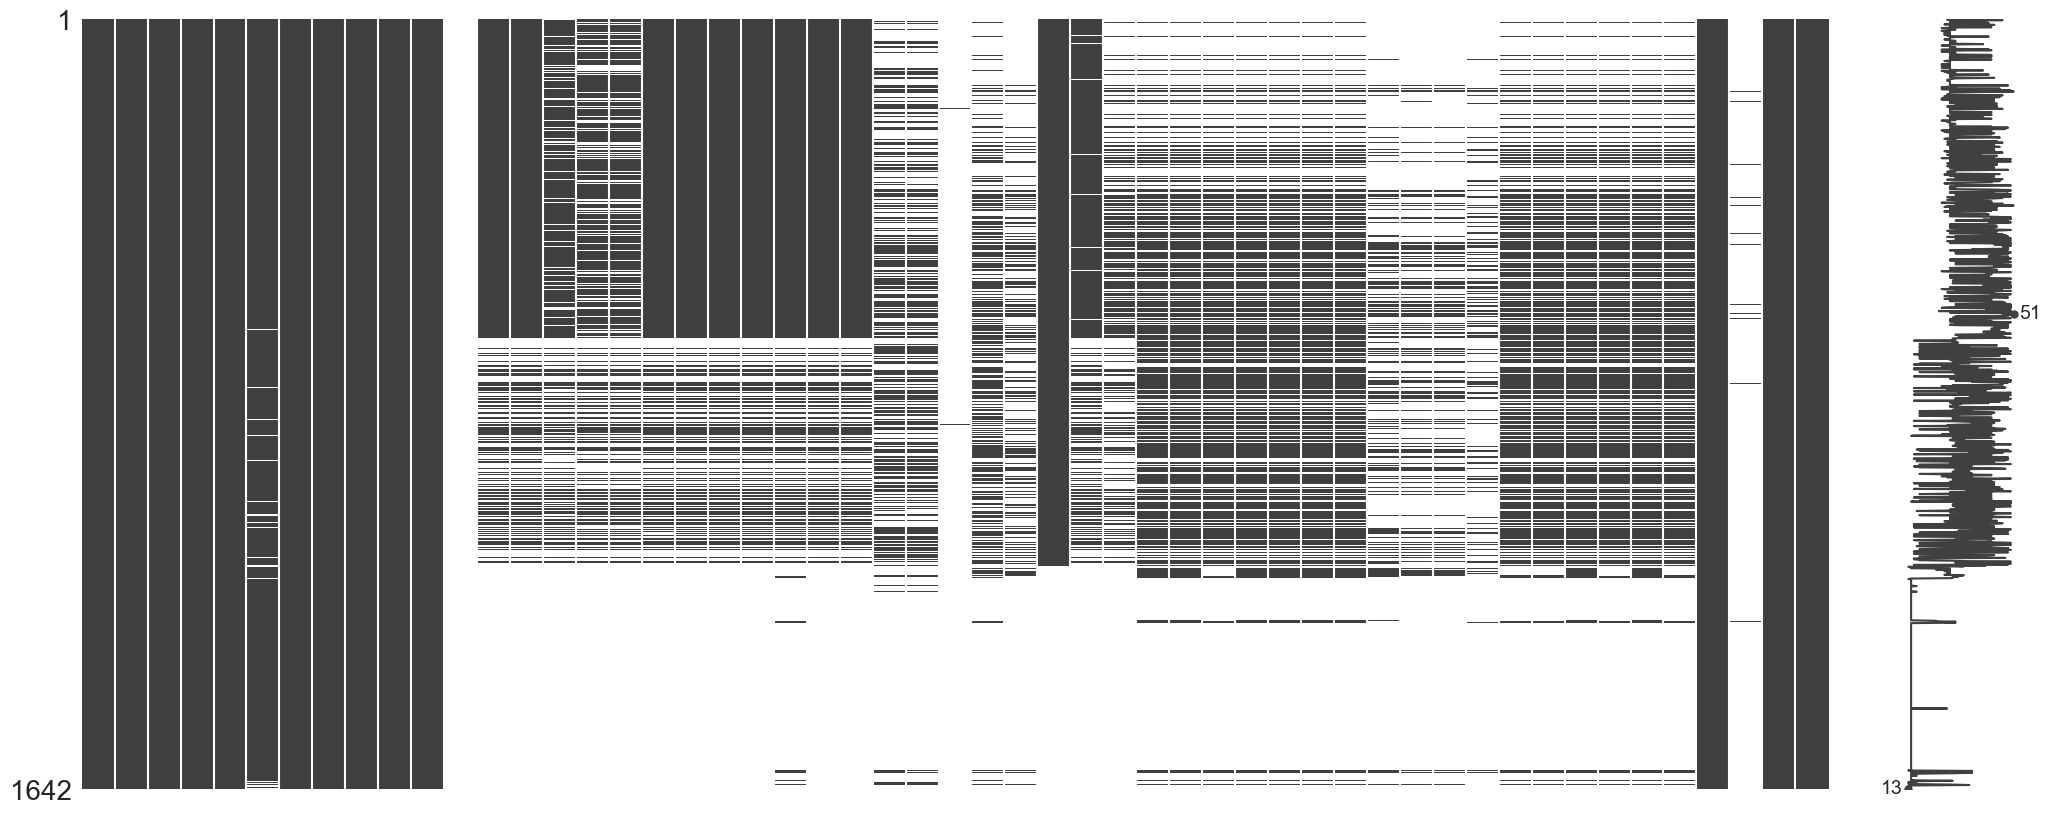

In [3]:
missingno.matrix(df)

<AxesSubplot: >

C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 24037 (\N{CJK UNIFIED IDEOGRAPH-5DE5}) missing from current font.
  func(*args, **kwargs)
C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from current font.
  func(*args, **kwargs)
C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from current font.
  func(*args, **kwargs)
C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from current font.
  func(*args, **kwargs)
C:\ProgramData\Anaconda3\envs\pythonProject_anaconda\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 20379 (\N{CJK UNIFIED IDEOGRAPH-4F9B}) missing from cur

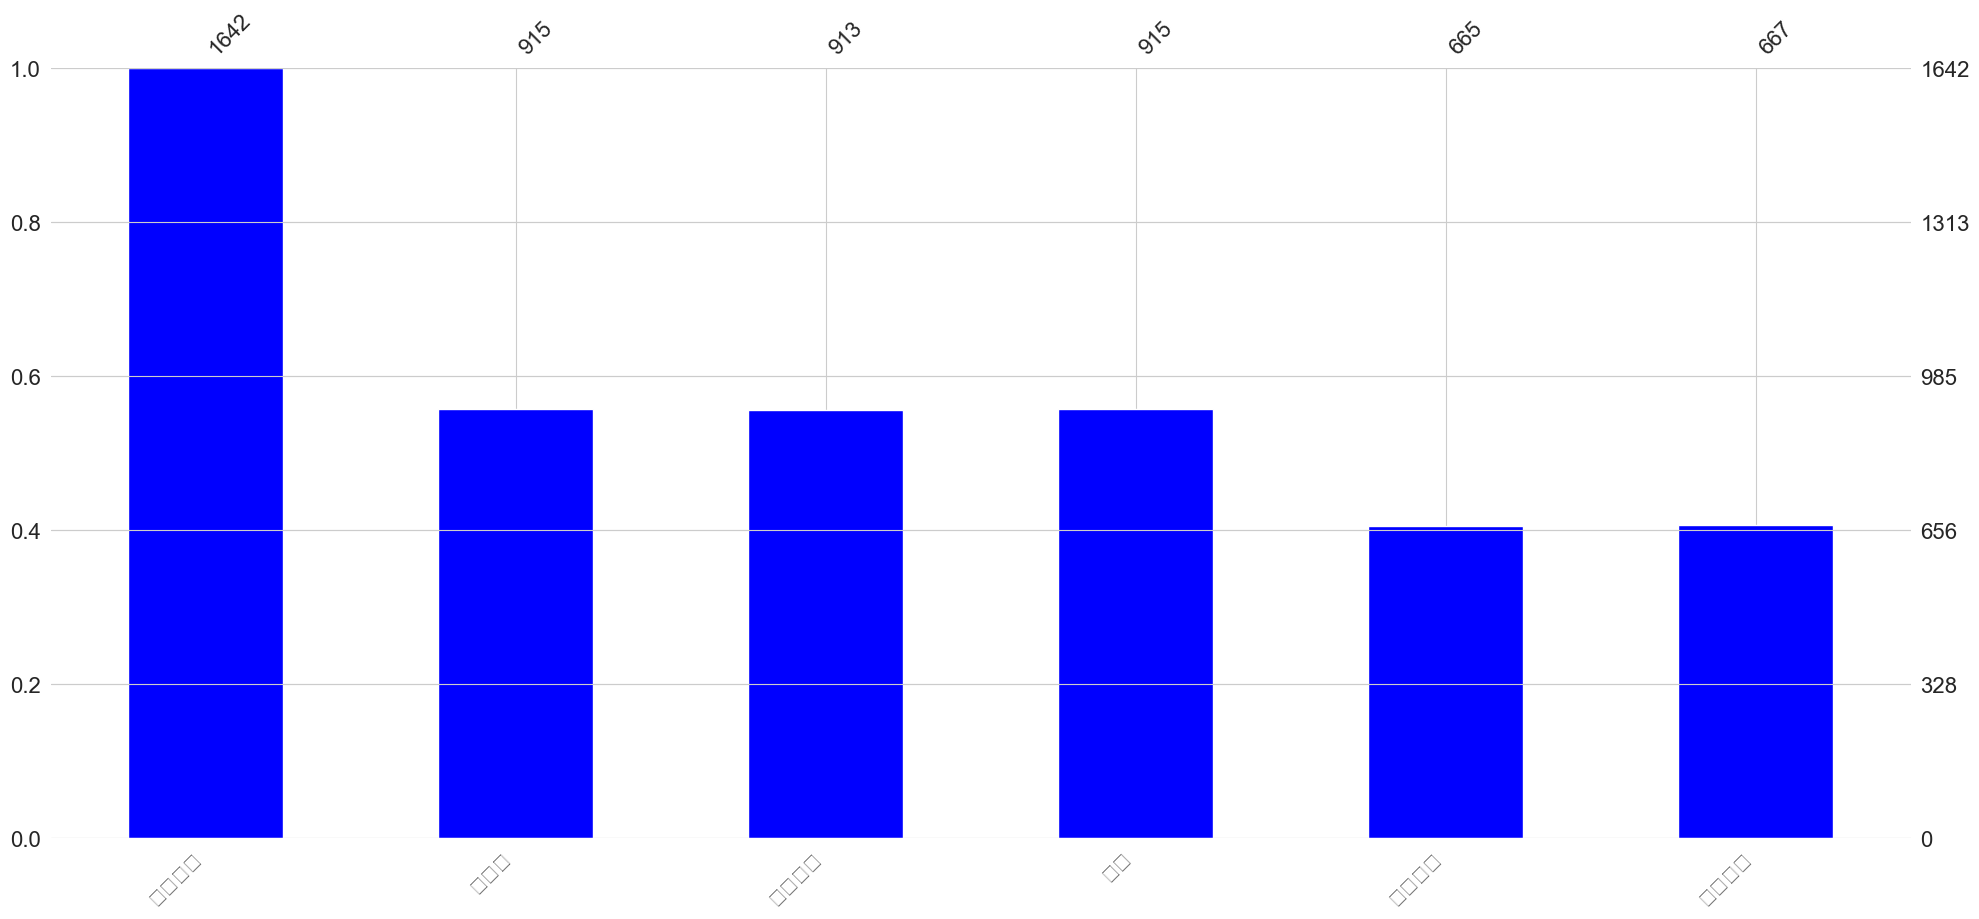

In [8]:
lipei2 = df[['工单编号','供应商','承保公司','险种',
                  '赔付金额','理赔时效']]
missingno.bar(lipei2,color='blue')

In [83]:
df.index
df.head()

Int64Index([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], dtype='int64')

1,地市名称,电信业务总量（亿元),电信业务总量（亿元),电信业务收入（亿元),电信业务收入（亿元),固定电话用户（万户）,移动电话用户（万户）,5G用户（万户）,固定宽带用户（万户）,FTTH/O光纤接入用户（万户）
7,东莞,100.3,19.4%,105.3,8.4%,213.5,1655.8,583.5,421.7,388.2
8,中山,38.4,23.8%,38.5,8.2%,89.5,694.1,226.9,204.6,191.3
9,江门,27.9,26.8%,30.0,7.8%,91.0,566.0,163.4,184.0,171.0
10,佛山,73.1,24.7%,83.9,9.4%,199.0,1250.7,384.5,343.0,323.5
11,肇庆,19.4,19.9%,19.9,5.6%,56.6,416.1,112.8,124.2,117.8


In [97]:
from requests_html import HTMLSession
import pandas as pd
url  = 'https://gdca.miit.gov.cn/zwgk/txfz/art/2022/art_983086ff767d487ebe11973b975e9a49.html'
session = HTMLSession()
response = session.get(url)
df2 = pd.read_html(response.text)[2][1:]
df2.head()

ModuleNotFoundError: No module named 'requests_html'

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"